### This notebook plots the perforance of equal shares and utilitarian greedy (along with their exclusive version) for the impact metrics of budget share, winning rate, cost representation and project representation in the form of a box plot. Additional boxplot for the novelty metrics along each impact area is also shown in the same plot at the end

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [2]:
# use this code block to set column and row viewing size/width
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 30)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

pd.options.display.float_format = '{:.4f}'.format

In [3]:
# read the metadata csv
pbsummary_df = pd.read_csv('../metadata.csv', delimiter=';')
pbsummary_df = pbsummary_df.drop_duplicates()
pbsummary_df

pbsummary_aarau = pd.read_csv('../metadata_aarau.csv', delimiter=';')
pbsummary_df = pd.concat([pbsummary_df, pbsummary_aarau], ignore_index=True)

pbsummary_df['subunit'].fillna(value='all', inplace=True)

In [4]:
# Get election id and vote type, so we know better to segragate approval and score votings
pbsummary_with_vote_type = pbsummary_df[['election_id', 'vote_type']]

In [5]:
# reading the projects CSV and loading to dataframe
pbprojects_df = pd.read_csv('../projects.csv', delimiter=';')
pbprojects_df.drop_duplicates(inplace=True)
print(pbprojects_df.shape)

pbprojects_aarau = pd.read_csv('../projects_aarau.csv', delimiter=';')
pbprojects_df = pd.concat([pbprojects_df, pbprojects_aarau], ignore_index=True)

# merge the column vote_type into pbprojects_df
pbprojects_df = pd.merge(pbprojects_df, pbsummary_with_vote_type, on='election_id', how='inner')
print(pbprojects_df.shape)

(19077, 21)
(19110, 22)


In [6]:
# Excluding that single project id by checking with particular election id and project id
valid_pbprojects_df = pbprojects_df[pbprojects_df['cost'] != 0]
print(pbprojects_df.shape)
print(valid_pbprojects_df.shape)

(19110, 22)
(19109, 22)


In [7]:
# There are citywide elections (unit-level); i.e. subunit is na, for such records fill na columns with values for subunit as all
valid_pbprojects_df['subunit'].fillna(value='all', inplace=True)

C:\Users\scsmah\AppData\Local\Temp\ipykernel_26824\3781473646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_pbprojects_df['subunit'].fillna(value='all', inplace=True)


In [8]:
# setting up vote_percent column
valid_pb_projects_total_selections = valid_pbprojects_df.groupby(['election_id'])['votes'].sum().reset_index()
valid_pb_projects_total_selections.rename(columns={'votes': 'total_votes_selection'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_total_selections, on='election_id', how='inner')
valid_pbprojects_df['vote_percent'] = round((valid_pbprojects_df['votes'] / valid_pbprojects_df['total_votes_selection'] * 100),3)

In [9]:
# Election ID for City Idea and Green Million
aarau_election_id = valid_pbprojects_df[valid_pbprojects_df['country'] == 'Switzerland'].groupby(['election_id']).first().reset_index()['election_id']
aarau_election_id = aarau_election_id.values[0]

green_budget_election_id = valid_pbprojects_df[valid_pbprojects_df['unit'] == 'Wieliczka'].groupby(['election_id']).first().reset_index()['election_id']
green_budget_election_id = green_budget_election_id.values[0]

In [10]:
# setting additional column for used budget with MES aggregation
print(valid_pbprojects_df.shape)

elections_with_mes_winners = valid_pbprojects_df[valid_pbprojects_df['is_mes_winner'] == True]
elections_with_greedy_winners = valid_pbprojects_df[valid_pbprojects_df['is_greedy_winner'] == True]


# Getting the total budget usage for MES winning projects of each election_id (grouped) and adding a new column to denote that value
valid_pb_projects_mes_budget_usage = valid_pbprojects_df[valid_pbprojects_df['is_mes_winner'] == True].groupby(['election_id'])['cost'].sum().reset_index()
valid_pb_projects_mes_budget_usage.rename(columns={'cost': 'mes_total_budget_usage'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_mes_budget_usage, on='election_id', how='inner')
valid_pbprojects_df['mes_budget_usage_percent'] = round((valid_pbprojects_df['mes_total_budget_usage'] / valid_pbprojects_df['total_budget'] * 100),3)

(19109, 24)


## Fill empty values for category with the label 'uncategorized' to aid in further data analysis

In [11]:
valid_pbprojects_df['category'].value_counts()

# Checking to see if there are empty values for category in the entire project dataset
na_category_count = valid_pbprojects_df['category'].isna().sum()
print("Empty category values for PB projects are: ", na_category_count)

# Fill such empty values of category with the label uncategorized, so that it can aid in further data preprocessing
valid_pbprojects_df['category'].fillna('uncategorized', inplace=True)


print("Emtpy category values after filling na: ", valid_pbprojects_df['category'].isna().sum())
print("`uncategorized` category count for valid pb projects: ", valid_pbprojects_df[valid_pbprojects_df['category'] == 'uncategorized'].shape[0])

Empty category values for PB projects are:  8182
Emtpy category values after filling na:  0
`uncategorized` category count for valid pb projects:  8182


#### The column `category` contains multiple categories embedded into the column separated by commas, let's do some data processing so that we select only first signifiying category. We store this into a new column called `major_category`

In [12]:
def trimCategoryText(category_text):
    return category_text.split(',')[0]

valid_pbprojects_df['major_category'] = valid_pbprojects_df['category'].apply(trimCategoryText)
valid_pbprojects_df['major_category'].nunique()


10

## Create additional columns for each category label

In [13]:
# Split the Categories column and create a set of unique categories
categories_set = set(category.strip() for categories in valid_pbprojects_df['category'] for category in categories.split(','))

# Create new columns with default value 0
for category in categories_set:
    valid_pbprojects_df[f'category_{category}'] = 0

# Iterate through rows and update the new columns
for index, row in valid_pbprojects_df.iterrows():
    categories = row['category'].split(',')
    for category in categories:
        valid_pbprojects_df.at[index, f'category_{category.strip()}'] = 1
    
    if(len(categories) == 1 and (categories[0] == 'uncategorized')):
        valid_pbprojects_df.at[index, 'category_labels_count'] = 0
    else:
        valid_pbprojects_df.at[index, 'category_labels_count'] = int(len(categories))

## Check to see if there are other labelled categories there were in between the commas but not in the major categories. This is not at a single project level, but the entire dataset level

In [14]:
major_categories_list = valid_pbprojects_df['major_category'].unique().tolist()
print(major_categories_list)
unlisted_minor_categories = []

for idx, row in valid_pbprojects_df.iterrows():
    category_text = row['category']
    cat_list = category_text.split(',')
    for item in cat_list:
        if item not in major_categories_list:
            unlisted_minor_categories.append(item)


print("Unlisted minor categories: ", unlisted_minor_categories)


['uncategorized', 'public transit and roads', 'public space', 'education', 'culture', 'sport', 'environmental protection', 'health', 'welfare', 'urban greenery']
Unlisted minor categories:  []


## For each instance of PB normalize project costs with min-max normalization

In [15]:
instance_grouped_max_pbprojects_df = valid_pbprojects_df.groupby(['election_id'])['cost'].max().reset_index()
instance_grouped_max_pbprojects_df.rename(columns={'cost': 'election_project_max_cost'}, inplace=True)

instance_grouped_min_pbprojects_df = valid_pbprojects_df.groupby(['election_id'])['cost'].min().reset_index()
instance_grouped_min_pbprojects_df.rename(columns={'cost': 'election_project_min_cost'}, inplace=True)

instance_grouped_total_projects_cost_df = valid_pbprojects_df.groupby(['election_id'])['cost'].sum().reset_index()
instance_grouped_total_projects_cost_df.rename(columns={'cost': 'total_projects_cost'}, inplace=True)

print("Valid PB Projects Shape before merge: ", valid_pbprojects_df.shape)
valid_pbprojects_df = valid_pbprojects_df.merge(instance_grouped_max_pbprojects_df, on='election_id', how='inner')
valid_pbprojects_df = valid_pbprojects_df.merge(instance_grouped_min_pbprojects_df, on='election_id', how='inner')
valid_pbprojects_df = valid_pbprojects_df.merge(instance_grouped_total_projects_cost_df, on='election_id', how='inner')
print("After merge: ", valid_pbprojects_df.shape)

def applyMinMaxNormalization(row):
    if ((row['cost'] == row['election_project_max_cost']) & (row['cost'] == row['election_project_min_cost'])):
        return 0.5
    else:
        return ((row['cost'] - row['election_project_min_cost']) / (row['election_project_max_cost'] - row['election_project_min_cost']))

valid_pbprojects_df['normalized_cost'] = valid_pbprojects_df.apply(lambda row: applyMinMaxNormalization(row), axis=1)

Valid PB Projects Shape before merge:  (19109, 38)
After merge:  (19109, 41)


In [16]:
# Group valid_pbprojects_df and create a new dataframe for each grouped average results
instance_overall_avg_cost = valid_pbprojects_df.groupby(['election_id'])['normalized_cost'].mean().reset_index()
instance_overall_avg_cost.rename(columns={'normalized_cost': 'normalized_overall_avg_cost'}, inplace=True)

instance_greedy_winner_avg_cost = valid_pbprojects_df[(valid_pbprojects_df['is_greedy_winner'] == True)].groupby('election_id')['normalized_cost'].mean().reset_index()
instance_greedy_winner_avg_cost.rename(columns={'normalized_cost': 'normalized_greedy_avg_cost'}, inplace=True)
instance_overall_df = instance_overall_avg_cost.merge(instance_greedy_winner_avg_cost, on='election_id', how='inner')


instance_mes_winner_avg_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True)].groupby('election_id')['normalized_cost'].mean().reset_index()
instance_mes_winner_avg_cost.rename(columns={'normalized_cost': 'normalized_mes_avg_cost'}, inplace=True)
instance_overall_df = instance_overall_df.merge(instance_mes_winner_avg_cost, on='election_id', how='inner')

instance_either_winner_avg_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] ==True) | (valid_pbprojects_df['is_greedy_winner'] == True)].groupby('election_id')['normalized_cost'].mean().reset_index()
instance_either_winner_avg_cost.rename(columns={'normalized_cost': 'normalized_either_avg_cost'}, inplace=True)
instance_overall_df = instance_overall_df.merge(instance_either_winner_avg_cost, on='election_id', how='inner')

instance_neither_winner_avg_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == False) & (valid_pbprojects_df['is_greedy_winner'] == False)].groupby('election_id')['normalized_cost'].mean().reset_index()
instance_neither_winner_avg_cost.rename(columns={'normalized_cost': 'normalized_neither_avg_cost'}, inplace=True)
instance_overall_df = instance_overall_df.merge(instance_neither_winner_avg_cost, on='election_id', how='left')

instance_both_winner_avg_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['is_greedy_winner'] == True)].groupby('election_id')['normalized_cost'].mean().reset_index()
instance_both_winner_avg_cost.rename(columns={'normalized_cost': 'normalized_both_avg_cost'}, inplace=True)
instance_overall_df = instance_overall_df.merge(instance_both_winner_avg_cost, on='election_id', how='left')

instance_only_greedy_winner_avg_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == False) & (valid_pbprojects_df['is_greedy_winner'] == True)].groupby('election_id')['normalized_cost'].mean().reset_index()
instance_only_greedy_winner_avg_cost.rename(columns={'normalized_cost': 'normalized_only_greedy_avg_cost'}, inplace=True)
instance_overall_df = instance_overall_df.merge(instance_only_greedy_winner_avg_cost, on='election_id', how='left')

instance_only_mes_winner_avg_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['is_greedy_winner'] == False)].groupby('election_id')['normalized_cost'].mean().reset_index()
instance_only_mes_winner_avg_cost.rename(columns={'normalized_cost': 'normalized_only_mes_avg_cost'}, inplace=True)
instance_overall_df = instance_overall_df.merge(instance_only_mes_winner_avg_cost, on='election_id', how='left')

# Fill non-existent values for instance_overall_df with values equal to -1. -1 because we had already normalized values between 0 and 1
instance_overall_df.fillna(-1, inplace=True)
print(instance_overall_df.shape)

(812, 9)


In [17]:
valid_pbprojects_df.columns

Index(['election_id', 'country', 'unit', 'subunit', 'instance', 'project_id',
       'cost', 'project_voters_count', 'votes', 'score', 'category', 'name',
       'englishName', 'target', 'total_budget', 'budget_percent',
       'is_mes_winner', 'is_greedy_winner', 'is_phragmen_winner', 'latitude',
       'longitude', 'vote_type', 'total_votes_selection', 'vote_percent',
       'mes_total_budget_usage', 'mes_budget_usage_percent', 'major_category',
       'category_education', 'category_public space',
       'category_urban greenery', 'category_public transit and roads',
       'category_sport', 'category_welfare', 'category_uncategorized',
       'category_culture', 'category_environmental protection',
       'category_health', 'category_labels_count', 'election_project_max_cost',
       'election_project_min_cost', 'total_projects_cost', 'normalized_cost'],
      dtype='object')

## Create a replica of the valid_pbprojects_df and find the distribution % of PB winners across different categories using MES against Greedy

In [18]:
categorization_df = valid_pbprojects_df
categorization_df = categorization_df[[
       'election_id', 'unit', 'subunit', 'instance', 'project_id', 'cost', 'target', 'total_projects_cost', 'votes', 'score', 'vote_type', 'is_mes_winner', 'is_greedy_winner', 'is_phragmen_winner', 'category', 'category_public transit and roads',
       'category_health', 'category_welfare', 'category_uncategorized',
       'category_public space', 'category_urban greenery', 'category_culture',
       'category_education', 'category_sport',
       'category_environmental protection', 'category_labels_count'
]]
categorization_df.rename(columns={'category_education': 'education', 'category_public transit and roads': 'public_transit_and_roads', 'category_health': 'health', 'category_welfare': 'welfare', 'category_uncategorized':'uncategorized', 'category_public space': 'public_space', 'category_urban greenery': 'urban_greenery', 'category_culture': 'culture', 'category_sport': 'sport', 'category_environmental protection': 'env_protection', 'category_labels_count': 'total_tags' }, inplace=True)
categorization_df = categorization_df[categorization_df['uncategorized'] == 0]



C:\Users\scsmah\AppData\Local\Temp\ipykernel_26824\1411517057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorization_df.rename(columns={'category_education': 'education', 'category_public transit and roads': 'public_transit_and_roads', 'category_health': 'health', 'category_welfare': 'welfare', 'category_uncategorized':'uncategorized', 'category_public space': 'public_space', 'category_urban greenery': 'urban_greenery', 'category_culture': 'culture', 'category_sport': 'sport', 'category_environmental protection': 'env_protection', 'category_labels_count': 'total_tags' }, inplace=True)


In [19]:
# some globals to be used for the code snippets below
categories_set = ['education', 'public_transit_and_roads', 'health', 'welfare', 'public_space', 'urban_greenery', 'culture', 'sport', 'env_protection']

In [20]:
categorization_df.columns

Index(['election_id', 'unit', 'subunit', 'instance', 'project_id', 'cost',
       'target', 'total_projects_cost', 'votes', 'score', 'vote_type',
       'is_mes_winner', 'is_greedy_winner', 'is_phragmen_winner', 'category',
       'public_transit_and_roads', 'health', 'welfare', 'uncategorized',
       'public_space', 'urban_greenery', 'culture', 'education', 'sport',
       'env_protection', 'total_tags'],
      dtype='object')

In [21]:
# update votes column to have score values for cumulative voting instances
categorization_df['votes'] = np.where(categorization_df['vote_type'] == 'cumulative', categorization_df['score'], categorization_df['votes'])

## Use the categorization_df dataframe as a base and add new metrics necessary for calculating cost utilization and relative winners for each category of each PB instance

In [22]:
# for each category; add columns that signify the total cost of each category per PB instance
# Create columns to store selection of percentages

# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # category_total_cost
    category_total_cost = categorization_df[categorization_df[category] == 1].groupby(['election_id'])['cost'].sum().reset_index()
    category_total_cost.rename(columns={'cost': f'{category}_total_cost'}, inplace=True)
    categorization_df = categorization_df.merge(category_total_cost, how='left', on='election_id')

    # category_total_projects
    category_total_projects = categorization_df[categorization_df[category] == 1].groupby(['election_id'])['project_id'].count().reset_index()
    category_total_projects.rename(columns={'project_id': f'{category}_projects_count'}, inplace=True)
    categorization_df = categorization_df.merge(category_total_projects, how='left', on='election_id')

    # category_total_popularity
    category_total_popularity = categorization_df[categorization_df[category] == 1].groupby(['election_id'])['votes'].sum().reset_index()
    category_total_popularity.rename(columns={'votes': f'{category}_total_popularity'}, inplace=True)
    categorization_df = categorization_df.merge(category_total_popularity, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'{category}_total_cost'].fillna(0, inplace=True)
    categorization_df[f'{category}_projects_count'].fillna(0, inplace=True)
    categorization_df[f'{category}_total_popularity'].fillna(0, inplace=True)

In [23]:
# Add 4 columns that denote; MES Winners Projects Count, MES Winners Project Costs, Greedy Winners Projects Count and Greedy Winners Project Cost; (overall)
es_total_cost = categorization_df[(categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
es_total_cost.rename(columns={'cost': 'es_total_cost'}, inplace=True)

ug_total_cost = categorization_df[(categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
ug_total_cost.rename(columns={'cost': 'ug_total_cost'}, inplace=True)

es_total_popularity = categorization_df[(categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['votes'].sum().reset_index()
es_total_popularity.rename(columns={'votes': 'es_total_popularity'}, inplace=True)

ug_total_popularity = categorization_df[(categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['votes'].sum().reset_index()
ug_total_popularity.rename(columns={'votes': 'ug_total_popularity'}, inplace=True)

es_total_projects = categorization_df[(categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
es_total_projects.rename(columns={'project_id': 'es_total_projects'}, inplace=True)

ug_total_projects = categorization_df[(categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
ug_total_projects.rename(columns={'project_id': 'ug_total_projects'}, inplace=True)

# Merge these dataset with categorization_df
categorization_df = categorization_df.merge(es_total_cost, on='election_id', how='inner')
categorization_df = categorization_df.merge(ug_total_cost, on='election_id', how='inner')
categorization_df = categorization_df.merge(es_total_projects, on='election_id', how='inner')
categorization_df = categorization_df.merge(ug_total_projects, on='election_id', how='inner')
categorization_df = categorization_df.merge(es_total_popularity, on='election_id', how='inner')
categorization_df = categorization_df.merge(ug_total_popularity, on='election_id', how='inner')

In [24]:
# Add another 4 columns that denote; only MES Winners Projects Count, only MES Winners Project Costs, only Greedy Winners Projects Count and only Greedy Winners Project Cost; (overall)
excl_es_total_cost = categorization_df[(categorization_df['is_mes_winner'] == True) & (categorization_df['is_greedy_winner'] == False)].groupby(['election_id'])['cost'].sum().reset_index()
excl_es_total_cost.rename(columns={'cost': 'excl_es_total_cost'}, inplace=True)

excl_ug_total_cost = categorization_df[(categorization_df['is_greedy_winner'] == True) & (categorization_df['is_mes_winner'] == False)].groupby(['election_id'])['cost'].sum().reset_index()
excl_ug_total_cost.rename(columns={'cost': 'excl_ug_total_cost'}, inplace=True)

excl_es_total_projects = categorization_df[(categorization_df['is_mes_winner'] == True) & (categorization_df['is_greedy_winner'] == False)].groupby(['election_id'])['project_id'].count().reset_index()
excl_es_total_projects.rename(columns={'project_id': 'excl_es_total_projects'}, inplace=True)

excl_ug_total_projects = categorization_df[(categorization_df['is_greedy_winner'] == True) & (categorization_df['is_mes_winner'] == False)].groupby(['election_id'])['project_id'].count().reset_index()
excl_ug_total_projects.rename(columns={'project_id': 'excl_ug_total_projects'}, inplace=True)

excl_es_total_popularity = categorization_df[(categorization_df['is_mes_winner'] == True) & (categorization_df['is_greedy_winner'] == False)].groupby(['election_id'])['votes'].sum().reset_index()
excl_es_total_popularity.rename(columns={'votes': 'excl_es_total_popularity'}, inplace=True)

excl_ug_total_popularity = categorization_df[(categorization_df['is_greedy_winner'] == True) & (categorization_df['is_mes_winner'] == False)].groupby(['election_id'])['votes'].sum().reset_index()
excl_ug_total_popularity.rename(columns={'votes': 'excl_ug_total_popularity'}, inplace=True)

# Merge these dataset with categorization_df; for only, we will need to use left join, because there can be cases where
# both outcomes are the same, in such cases only values don't exist; so left join is needed
categorization_df = categorization_df.merge(excl_es_total_cost, on='election_id', how='left')
categorization_df = categorization_df.merge(excl_ug_total_cost, on='election_id', how='left')
categorization_df = categorization_df.merge(excl_es_total_projects, on='election_id', how='left')
categorization_df = categorization_df.merge(excl_ug_total_projects, on='election_id', how='left')
categorization_df = categorization_df.merge(excl_es_total_popularity, on='election_id', how='left')
categorization_df = categorization_df.merge(excl_ug_total_popularity, on='election_id', how='left')

In [25]:
# Merge categorization_df with pbsummary to get total projects in all elections
pbsummary_num_votes = pbsummary_df[['election_id', 'num_projects']]
categorization_df = categorization_df.merge(pbsummary_num_votes, on='election_id', how='inner')

In [26]:
# Adding total cost of each category in each election for greedy winners

# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # category ug total cost
    category_ug_total_cost = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
    category_ug_total_cost.rename(columns={'cost': f'{category}_ug_total_cost'}, inplace=True)
    categorization_df = categorization_df.merge(category_ug_total_cost, how='left', on='election_id')

    # category es total cost
    category_es_total_cost = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
    category_es_total_cost.rename(columns={'cost': f'{category}_es_total_cost'}, inplace=True)
    categorization_df = categorization_df.merge(category_es_total_cost, how='left', on='election_id')

    # category_ug_total_projects
    category_ug_total_projects = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
    category_ug_total_projects.rename(columns={'project_id': f'{category}_ug_total_projects'}, inplace=True)
    categorization_df = categorization_df.merge(category_ug_total_projects, how='left', on='election_id')

    # category_es_total_projects
    category_es_total_projects = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
    category_es_total_projects.rename(columns={'project_id': f'{category}_es_total_projects'}, inplace=True)
    categorization_df = categorization_df.merge(category_es_total_projects, how='left', on='election_id')

    # category_ug_total_popularity
    category_ug_total_popularity = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['votes'].sum().reset_index()
    category_ug_total_popularity.rename(columns={'votes': f'{category}_ug_total_popularity'}, inplace=True)
    categorization_df = categorization_df.merge(category_ug_total_popularity, how='left', on='election_id')

    # category_es_total_popularity
    category_es_total_popularity = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['votes'].sum().reset_index()
    category_es_total_popularity.rename(columns={'votes': f'{category}_es_total_popularity'}, inplace=True)
    categorization_df = categorization_df.merge(category_es_total_popularity, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'{category}_ug_total_cost'].fillna(0, inplace=True)
    categorization_df[f'{category}_es_total_cost'].fillna(0, inplace=True)
    categorization_df[f'{category}_ug_total_projects'].fillna(0, inplace=True)
    categorization_df[f'{category}_es_total_projects'].fillna(0, inplace=True)
    categorization_df[f'{category}_ug_total_popularity'].fillna(0, inplace=True)
    categorization_df[f'{category}_es_total_popularity'].fillna(0, inplace=True)


In [27]:
# Project counts in each category that are Greedy winners only

# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # category_excl_ug_total_projects
    category_excl_ug_total_projects = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True) & (categorization_df['is_mes_winner'] == False)].groupby(['election_id'])['project_id'].count().reset_index()
    category_excl_ug_total_projects.rename(columns={'project_id': f'{category}_excl_ug_total_projects'}, inplace=True)
    categorization_df = categorization_df.merge(category_excl_ug_total_projects, how='left', on='election_id')

    # category_excl_es_total_projects
    category_excl_es_total_projects = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True) & (categorization_df['is_greedy_winner'] == False)].groupby(['election_id'])['project_id'].count().reset_index()
    category_excl_es_total_projects.rename(columns={'project_id': f'{category}_excl_es_total_projects'}, inplace=True)
    categorization_df = categorization_df.merge(category_excl_es_total_projects, how='left', on='election_id')

    # category_excl_ug_total_cost
    category_excl_ug_total_cost = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True) & (categorization_df['is_mes_winner'] == False)].groupby(['election_id'])['cost'].sum().reset_index()
    category_excl_ug_total_cost.rename(columns={'cost': f'{category}_excl_ug_total_cost'}, inplace=True)
    categorization_df = categorization_df.merge(category_excl_ug_total_cost, how='left', on='election_id')

    # category_excl_es_total_cost
    category_excl_es_total_cost = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True) & (categorization_df['is_greedy_winner'] == False)].groupby(['election_id'])['cost'].sum().reset_index()
    category_excl_es_total_cost.rename(columns={'cost': f'{category}_excl_es_total_cost'}, inplace=True)
    categorization_df = categorization_df.merge(category_excl_es_total_cost, how='left', on='election_id')

    # category_excl_ug_total_popularity
    category_excl_ug_total_popularity = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True) & (categorization_df['is_mes_winner'] == False)].groupby(['election_id'])['votes'].sum().reset_index()
    category_excl_ug_total_popularity.rename(columns={'votes': f'{category}_excl_ug_total_popularity'}, inplace=True)
    categorization_df = categorization_df.merge(category_excl_ug_total_popularity, how='left', on='election_id')

    # category_excl_es_total_popularity
    category_excl_es_total_popularity = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True) & (categorization_df['is_greedy_winner'] == False)].groupby(['election_id'])['votes'].sum().reset_index()
    category_excl_es_total_popularity.rename(columns={'votes': f'{category}_excl_es_total_popularity'}, inplace=True)
    categorization_df = categorization_df.merge(category_excl_es_total_popularity, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'{category}_excl_ug_total_projects'].fillna(0, inplace=True)
    categorization_df[f'{category}_excl_es_total_projects'].fillna(0, inplace=True)
    categorization_df[f'{category}_excl_ug_total_cost'].fillna(0, inplace=True)
    categorization_df[f'{category}_excl_es_total_cost'].fillna(0, inplace=True)
    categorization_df[f'{category}_excl_es_total_popularity'].fillna(0, inplace=True)
    categorization_df[f'{category}_excl_ug_total_popularity'].fillna(0, inplace=True)



##  Metrics for Budget Share and Winning Rate

In [28]:
# metrics calculation required for relative winners
print("Current shape of categorization df is: ", categorization_df.shape)

for category in categories_set:
    categorization_df[f'{category}_ug_cost_share'] = 1 * categorization_df[f'{category}_ug_total_cost'] / categorization_df['ug_total_cost']
    categorization_df[f'{category}_es_cost_share'] = 1 * categorization_df[f'{category}_es_total_cost'] / categorization_df['es_total_cost']
    categorization_df[f'{category}_loss_cost_share'] = categorization_df[f'{category}_ug_cost_share'] - categorization_df[f'{category}_es_cost_share']

    categorization_df[f'{category}_ug_project_share'] = 1 * categorization_df[f'{category}_ug_total_projects'] / categorization_df['ug_total_projects']
    categorization_df[f'{category}_es_project_share'] = 1 * categorization_df[f'{category}_es_total_projects'] / categorization_df['es_total_projects']
    categorization_df[f'{category}_loss_project_share'] = categorization_df[f'{category}_ug_project_share'] - categorization_df[f'{category}_es_project_share']

    categorization_df[f'{category}_ug_popularity_share'] = 1 * categorization_df[f'{category}_ug_total_popularity'] / categorization_df['ug_total_popularity']
    categorization_df[f'{category}_es_popularity_share'] = 1 * categorization_df[f'{category}_es_total_popularity'] / categorization_df['es_total_popularity']
    categorization_df[f'{category}_loss_popularity_share'] = categorization_df[f'{category}_ug_popularity_share'] - categorization_df[f'{category}_es_popularity_share']
    
    categorization_df[f'{category}_excl_ug_cost_share'] = 1 * categorization_df[f'{category}_excl_ug_total_cost'] / categorization_df['ug_total_cost']
    categorization_df[f'{category}_excl_es_cost_share'] = 1 * categorization_df[f'{category}_excl_es_total_cost'] / categorization_df['es_total_cost']
    categorization_df[f'{category}_loss_excl_cost_share'] = categorization_df[f'{category}_excl_ug_cost_share'] - categorization_df[f'{category}_excl_es_cost_share']
    
    categorization_df[f'{category}_excl_ug_project_share'] = 1 * categorization_df[f'{category}_excl_ug_total_projects'] / categorization_df[f'ug_total_projects']
    categorization_df[f'{category}_excl_es_project_share'] = 1 * categorization_df[f'{category}_excl_es_total_projects'] / categorization_df[f'es_total_projects']
    categorization_df[f'{category}_loss_excl_project_share'] = categorization_df[f'{category}_excl_ug_project_share'] - categorization_df[f'{category}_excl_es_project_share']

    categorization_df[f'{category}_excl_ug_popularity_share'] = 1 * categorization_df[f'{category}_excl_ug_total_popularity'] / categorization_df[f'ug_total_popularity']
    categorization_df[f'{category}_excl_es_popularity_share'] = 1 * categorization_df[f'{category}_excl_es_total_popularity'] / categorization_df[f'es_total_popularity']
    categorization_df[f'{category}_loss_excl_popularity_share'] = categorization_df[f'{category}_excl_ug_popularity_share'] - categorization_df[f'{category}_excl_es_popularity_share']



Current shape of categorization df is:  (10927, 174)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_26824\3267733230.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'{category}_loss_project_share'] = categorization_df[f'{category}_ug_project_share'] - categorization_df[f'{category}_es_project_share']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_26824\3267733230.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'{category}_ug_popularity_share'] = 1 * categorization_df[f'{category}_ug_total_popularity'] / categorization_df['ug_total_popula

## Metrics for Cost and Project Representation

In [29]:
# New metrics required relative proposals in each category
print("Before adding new metrics, shape was: ", categorization_df.shape)
for category in categories_set:
    categorization_df[f'{category}_ug_cost_representation'] = 1 * categorization_df[f'{category}_ug_total_cost'] / categorization_df[f'{category}_total_cost']
    categorization_df[f'{category}_es_cost_representation'] = 1 * categorization_df[f'{category}_es_total_cost'] / categorization_df[f'{category}_total_cost']
    categorization_df[f'{category}_loss_cost_representation'] = categorization_df[f'{category}_ug_cost_representation'] - categorization_df[f'{category}_es_cost_representation']
    
    categorization_df[f'{category}_ug_project_representation'] = 1 * categorization_df[f'{category}_ug_total_projects'] / categorization_df[f'{category}_projects_count']
    categorization_df[f'{category}_es_project_representation'] = 1 * categorization_df[f'{category}_es_total_projects'] / categorization_df[f'{category}_projects_count']
    categorization_df[f'{category}_loss_project_representation'] = categorization_df[f'{category}_ug_project_representation'] - categorization_df[f'{category}_es_project_representation']

    categorization_df[f'{category}_ug_popularity_representation'] = 1 * categorization_df[f'{category}_ug_total_popularity'] / categorization_df[f'{category}_total_popularity']
    categorization_df[f'{category}_es_popularity_representation'] = 1 * categorization_df[f'{category}_es_total_popularity'] / categorization_df[f'{category}_total_popularity']
    categorization_df[f'{category}_loss_popularity_representation'] = 1 * categorization_df[f'{category}_ug_popularity_representation'] - categorization_df[f'{category}_es_popularity_representation']
    
    categorization_df[f'{category}_excl_ug_cost_representation'] = 1 * categorization_df[f'{category}_excl_ug_total_cost'] / categorization_df[f'{category}_total_cost']
    categorization_df[f'{category}_excl_es_cost_representation'] = 1 * categorization_df[f'{category}_excl_es_total_cost'] / categorization_df[f'{category}_total_cost']
    categorization_df[f'{category}_loss_excl_cost_representation'] = categorization_df[f'{category}_excl_ug_cost_representation'] - categorization_df[f'{category}_excl_es_cost_representation']

    categorization_df[f'{category}_excl_ug_project_representation'] = 1 * categorization_df[f'{category}_excl_ug_total_projects'] / categorization_df[f'{category}_projects_count']
    categorization_df[f'{category}_excl_es_project_representation'] = 1 * categorization_df[f'{category}_excl_es_total_projects'] / categorization_df[f'{category}_projects_count']
    categorization_df[f'{category}_loss_excl_project_representation'] = categorization_df[f'{category}_excl_ug_project_representation'] - categorization_df[f'{category}_excl_es_project_representation']

    categorization_df[f'{category}_excl_ug_popularity_representation'] = 1 * categorization_df[f'{category}_excl_ug_total_popularity'] / categorization_df[f'{category}_total_popularity']
    categorization_df[f'{category}_excl_es_popularity_representation'] = 1 * categorization_df[f'{category}_excl_es_total_popularity'] / categorization_df[f'{category}_total_popularity']
    categorization_df[f'{category}_loss_excl_popularity_representation'] = categorization_df[f'{category}_excl_ug_popularity_representation'] - categorization_df[f'{category}_excl_es_popularity_representation']

Before adding new metrics, shape was:  (10927, 336)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_26824\1737142466.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'{category}_ug_cost_representation'] = 1 * categorization_df[f'{category}_ug_total_cost'] / categorization_df[f'{category}_total_cost']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_26824\1737142466.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'{category}_es_cost_representation'] = 1 * categorization_df[f'{category}_es_total_cost'] / categorization_df[f'{category}_total_cos

## Metrics for Between and Within Cost and Count Novelty

In [30]:
# initialize empty column values for novelty metrics
for category in categories_set:
    categorization_df[f'{category}_within_novelty_cost'] = 0
    categorization_df[f'{category}_within_novelty_count'] = 0
    categorization_df[f'{category}_within_novelty_popularity'] = 0
    categorization_df[f'{category}_between_novelty_cost'] = 0
    categorization_df[f'{category}_between_novelty_count'] = 0
    categorization_df[f'{category}_between_novelty_popularity'] = 0

# define functions that update those values
## within group novelty cost
def calculateWithinNoveltyCost(row):
    for category in categories_set:
        if (row[f'{category}_ug_total_cost'] == 0) and (row[f'{category}_es_total_cost'] != 0):
            row[f'{category}_within_novelty_cost'] = (0 - (1 * row[f'{category}_excl_es_total_cost'] / row[f'{category}_es_total_cost']))
        elif (row[f'{category}_es_total_cost'] == 0) and (row[f'{category}_ug_total_cost'] != 0):
            row[f'{category}_within_novelty_cost'] = (1 * row[f'{category}_excl_ug_total_cost'] / row[f'{category}_ug_total_cost'])
        elif (row[f'{category}_es_total_cost'] == 0) and (row[f'{category}_ug_total_cost'] == 0):
            row[f'{category}_within_novelty_cost'] = 0
        else:
            row[f'{category}_within_novelty_cost'] = ((1 * row[f'{category}_excl_ug_total_cost'] / row[f'{category}_ug_total_cost']) - (1 * row[f'{category}_excl_es_total_cost'] / row[f'{category}_es_total_cost']))
    return row


# within group novelty count
def calculateWithinNoveltyCount(row):
    for category in categories_set:
        if (row[f'{category}_ug_total_projects'] == 0) and (row[f'{category}_es_total_projects'] != 0):
            row[f'{category}_within_novelty_count'] = (0 - (1 * row[f'{category}_excl_es_total_projects'] / row[f'{category}_es_total_projects']))
        elif (row[f'{category}_es_total_projects'] == 0) and (row[f'{category}_ug_total_projects'] != 0):
            row[f'{category}_within_novelty_count'] = (1 * row[f'{category}_excl_ug_total_projects'] / row[f'{category}_ug_total_projects'])
        elif (row[f'{category}_es_total_projects'] == 0) and (row[f'{category}_ug_total_projects'] == 0):
            row[f'{category}_within_novelty_count'] = 0
        else:
            row[f'{category}_within_novelty_count'] = ((1 * row[f'{category}_excl_ug_total_projects'] / row[f'{category}_ug_total_projects']) - (1 * row[f'{category}_excl_es_total_projects'] / row[f'{category}_es_total_projects']))
    return row

# within group novelty popularity
def calculateWithinNoveltyPopularity(row):
    for category in categories_set:
        if (row[f'{category}_ug_total_popularity'] == 0) and (row[f'{category}_es_total_popularity'] != 0):
            row[f'{category}_within_novelty_popularity'] = (0 - (1 * row[f'{category}_excl_es_total_popularity'] / row[f'{category}_es_total_popularity']))
        elif (row[f'{category}_es_total_popularity'] == 0) and (row[f'{category}_ug_total_popularity'] != 0):
            row[f'{category}_within_novelty_popularity'] = (1 * row[f'{category}_excl_ug_total_popularity'] / row[f'{category}_ug_total_popularity'])
        elif (row[f'{category}_es_total_popularity'] == 0) and (row[f'{category}_ug_total_popularity'] == 0):
            row[f'{category}_within_novelty_popularity'] = 0
        else:
            row[f'{category}_within_novelty_popularity'] = ((1 * row[f'{category}_excl_ug_total_popularity'] / row[f'{category}_ug_total_popularity']) - (1 * row[f'{category}_excl_es_total_popularity'] / row[f'{category}_es_total_popularity']))
    return row

# between novelty cost
def calculateBetweenNoveltyCost(row):
    for category in categories_set:
        if (row['excl_ug_total_cost'] == 0) and (row['excl_es_total_cost'] != 0):
            row[f'{category}_between_novelty_cost'] = (0 - (1 * row[f'{category}_excl_es_total_cost'] / row['excl_es_total_cost']))
        elif (row['excl_es_total_cost'] == 0) and (row['excl_ug_total_cost'] != 0):
            row[f'{category}_between_novelty_cost'] = (1 * row[f'{category}_excl_ug_total_cost'] / row['excl_ug_total_cost'])
        elif (row['excl_es_total_cost'] == 0) and (row['excl_ug_total_cost'] == 0):
            row[f'{category}_between_novelty_cost'] = 0
        else:
            row[f'{category}_between_novelty_cost'] = ((1 * row[f'{category}_excl_ug_total_cost'] / row['excl_ug_total_cost']) - (1 * row[f'{category}_excl_es_total_cost'] / row['excl_es_total_cost']))
    return row

# between groups novelty count
def calculateBetweenNoveltyCount(row):
    for category in categories_set:
        if (row['excl_ug_total_projects'] == 0) and (row['excl_es_total_projects'] != 0):
            row[f'{category}_between_novelty_count'] = (0 - (1 * row[f'{category}_excl_es_total_projects'] / row['excl_es_total_projects']))
        elif (row['excl_ug_total_projects'] != 0) and (row['excl_es_total_projects'] == 0):
            row[f'{category}_between_novelty_count'] = (1 * row[f'{category}_excl_ug_total_projects'] / row['excl_ug_total_projects'])
        elif (row['excl_ug_total_projects'] == 0) and (row['excl_es_total_projects'] == 0):
            row[f'{category}_between_novelty_count'] = 0
        else:
            row[f'{category}_between_novelty_count'] = ((1 * row[f'{category}_excl_ug_total_projects'] / row['excl_ug_total_projects']) - (1 * row[f'{category}_excl_es_total_projects'] / row['excl_es_total_projects']))
    return row

# between groups novelty popularity
def calculateBetweenNoveltyPopularity(row):
    for category in categories_set:
        if (row['excl_ug_total_popularity'] == 0) and (row['excl_es_total_popularity'] != 0):
            row[f'{category}_between_novelty_popularity'] = (0 - (1 * row[f'{category}_excl_es_total_popularity'] / row['excl_es_total_popularity']))
        elif (row['excl_ug_total_popularity'] != 0) and (row['excl_es_total_popularity'] == 0):
            row[f'{category}_between_novelty_popularity'] = (1 * row[f'{category}_excl_ug_total_popularity'] / row['excl_ug_total_popularity'])
        elif (row['excl_ug_total_popularity'] == 0) and (row['excl_es_total_popularity'] == 0):
            row[f'{category}_between_novelty_popularity'] = 0
        else:
            row[f'{category}_between_novelty_popularity'] = ((1 * row[f'{category}_excl_ug_total_popularity'] / row['excl_ug_total_popularity']) - (1 * row[f'{category}_excl_es_total_popularity'] / row['excl_es_total_popularity']))
    return row

# iterate across all rows of categorization_df and update the values
categorization_df = categorization_df.apply(lambda row: calculateWithinNoveltyCost(row), axis=1)
categorization_df = categorization_df.apply(lambda row: calculateWithinNoveltyCount(row), axis=1)
categorization_df = categorization_df.apply(lambda row: calculateWithinNoveltyPopularity(row), axis=1)
categorization_df = categorization_df.apply(lambda row: calculateBetweenNoveltyCost(row), axis=1)
categorization_df = categorization_df.apply(lambda row: calculateBetweenNoveltyCount(row), axis=1)
categorization_df = categorization_df.apply(lambda row: calculateBetweenNoveltyPopularity(row), axis=1)

C:\Users\scsmah\AppData\Local\Temp\ipykernel_26824\497428926.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'{category}_within_novelty_cost'] = 0
C:\Users\scsmah\AppData\Local\Temp\ipykernel_26824\497428926.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'{category}_within_novelty_count'] = 0
C:\Users\scsmah\AppData\Local\Temp\ipykernel_26824\497428926.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

## Hacking the dataset to select only instances for which there are exclusive winning outcomes by either MES or UG at each category level

In [31]:
for category in categories_set:
    cols_to_select = ['election_id', 
                            f'{category}_ug_cost_share', 
                            f'{category}_es_cost_share', 
                            f'{category}_loss_cost_share',

                            f'{category}_ug_project_share', 
                            f'{category}_es_project_share', 
                            f'{category}_loss_project_share', 

                            f'{category}_ug_popularity_share', 
                            f'{category}_es_popularity_share', 
                            f'{category}_loss_popularity_share', 
                            
                            f'{category}_excl_ug_cost_share', 
                            f'{category}_excl_es_cost_share',
                            f'{category}_loss_excl_cost_share',
                            
                            f'{category}_excl_ug_project_share',
                            f'{category}_excl_es_project_share',
                            f'{category}_loss_excl_project_share',

                            f'{category}_excl_ug_popularity_share',
                            f'{category}_excl_es_popularity_share',
                            f'{category}_loss_excl_popularity_share',

                            f'{category}_ug_cost_representation',
                            f'{category}_es_cost_representation',
                            f'{category}_loss_cost_representation',
                            
                            f'{category}_ug_project_representation',
                            f'{category}_es_project_representation',
                            f'{category}_loss_project_representation',

                            f'{category}_ug_popularity_representation',
                            f'{category}_es_popularity_representation',
                            f'{category}_loss_popularity_representation',
                            
                            f'{category}_excl_ug_cost_representation',
                            f'{category}_excl_es_cost_representation',
                            f'{category}_loss_excl_cost_representation',
                            
                            f'{category}_excl_ug_project_representation',
                            f'{category}_excl_es_project_representation',
                            f'{category}_loss_excl_project_representation', 

                            f'{category}_excl_ug_popularity_representation',
                            f'{category}_excl_es_popularity_representation',
                            f'{category}_loss_excl_popularity_representation', 

                            # additional columns for novelty measure
                            f'{category}_within_novelty_cost',
                            f'{category}_within_novelty_count',
                            f'{category}_within_novelty_popularity',
                            f'{category}_between_novelty_cost',
                            f'{category}_between_novelty_count',
                            f'{category}_between_novelty_popularity'
                        ]
    if category == 'education':
        education_df = categorization_df[cols_to_select]
        education_df.drop_duplicates(inplace=True)
        print(education_df.shape)
    if category == 'public_transit_and_roads':
        public_transit_and_roads_df = categorization_df[cols_to_select]
        public_transit_and_roads_df.drop_duplicates(inplace=True)
        print(public_transit_and_roads_df.shape)
    if category == 'health':
        health_df = categorization_df[cols_to_select]
        health_df.drop_duplicates(inplace=True)
        print(health_df.shape)
    if category == 'welfare':
        welfare_df = categorization_df[cols_to_select]
        welfare_df.drop_duplicates(inplace=True)
        print(welfare_df.shape)
    if category == 'public_space':
        public_space_df = categorization_df[cols_to_select]
        public_space_df.drop_duplicates(inplace=True)
        print(public_space_df.shape)
    if category == 'urban_greenery':
        urban_greenery_df = categorization_df[cols_to_select]
        urban_greenery_df.drop_duplicates(inplace=True)
        print(urban_greenery_df.shape)
    if category == 'culture':
        culture_df = categorization_df[cols_to_select]
        culture_df.drop_duplicates(inplace=True)
        print(culture_df.shape)
    if category == 'sport':
        sport_df = categorization_df[cols_to_select]
        sport_df.drop_duplicates(inplace=True)
        print(sport_df.shape)
    if category == 'env_protection':
        env_protection = categorization_df[cols_to_select]
        env_protection.drop_duplicates(inplace=True)
        print(env_protection.shape)

(346, 43)
(346, 43)
(346, 43)
(346, 43)
(346, 43)
(346, 43)
(346, 43)
(346, 43)
(346, 43)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_26824\3218265888.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  education_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_26824\3218265888.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public_transit_and_roads_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_26824\3218265888.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [32]:
education_df.describe()

,election_id,education_ug_cost_share,education_es_cost_share,education_loss_cost_share,education_ug_project_share,education_es_project_share,education_loss_project_share,education_ug_popularity_share,education_es_popularity_share,education_loss_popularity_share,education_excl_ug_cost_share,education_excl_es_cost_share,education_loss_excl_cost_share,education_excl_ug_project_share,education_excl_es_project_share,education_loss_excl_project_share,education_excl_ug_popularity_share,education_excl_es_popularity_share,education_loss_excl_popularity_share,education_ug_cost_representation,education_es_cost_representation,education_loss_cost_representation,education_ug_project_representation,education_es_project_representation,education_loss_project_representation,education_ug_popularity_representation,education_es_popularity_representation,education_loss_popularity_representation,education_excl_ug_cost_representation,education_excl_es_cost_representation,education_loss_excl_cost_representation,education_excl_ug_project_representation,education_excl_es_project_representation,education_loss_excl_project_representation,education_excl_ug_popularity_representation,education_excl_es_popularity_representation,education_loss_excl_popularity_representation,education_within_novelty_cost,education_within_novelty_count,education_within_novelty_popularity,education_between_novelty_cost,education_between_novelty_count,education_between_novelty_popularity
count,346.0000,346.0000,346.0000,346.0000,346.0000,346.0000,346.0000,346.0000,346.0000,346.0000,346.0000,346.0000,346.0000,346.0000,346.0000,346.0000,346.0000,346.0000,346.0000,328.0000,328.0000,328.0000,328.0000,328.0000,328.0000,328.0000,328.0000,328.0000,328.0000,328.0000,328.0000,328.0000,328.0000,328.0000,328.0000,328.0000,328.0000,346.0000,346.0000,346.0000,278.0000,278.0000,278.0000
mean,505.4335,0.2560,0.3533,-0.0973,0.3433,0.4326,-0.0892,0.3213,0.3895,-0.0682,0.0745,0.1600,-0.0855,0.0252,0.1964,-0.1711,0.0265,0.1320,-0.1055,0.4001,0.5491,-0.1490,0.4676,0.7841,-0.3165,0.5730,0.8221,-0.2490,0.0672,0.2162,-0.1490,0.0263,0.3428,-0.3165,0.0391,0.2881,-0.2490,-0.2857,-0.3515,-0.2645,-0.2708,-0.3274,-0.3026
std,103.1004,0.2462,0.2310,0.2073,0.2210,0.2080,0.1362,0.2206,0.2120,0.1079,0.1697,0.1528,0.1998,0.0593,0.1696,0.1673,0.0643,0.1245,0.1254,0.3415,0.3352,0.2873,0.3207,0.1916,0.2838,0.2959,0.1719,0.2640,0.1581,0.2252,0.2873,0.0927,0.2618,0.2838,0.1057,0.2414,0.2640,0.3915,0.3410,0.3078,0.4378,0.4220,0.4256
min,332.0000,0.0000,0.0000,-0.8957,0.0000,0.0000,-0.6500,0.0000,0.0000,-0.5339,0.0000,0.0000,-0.7031,0.0000,0.0000,-0.7500,0.0000,0.0000,-0.6353,0.0000,0.0000,-1.0000,0.0000,0.0000,-1.0000,0.0000,0.0000,-1.0000,0.0000,0.0000,-1.0000,0.0000,0.0000,-1.0000,0.0000,0.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
25%,418.2500,0.0589,0.1868,-0.2114,0.2000,0.2890,-0.1682,0.1608,0.2394,-0.1222,0.0000,0.0000,-0.2006,0.0000,0.0000,-0.2824,0.0000,0.0000,-0.1740,0.1194,0.2740,-0.2717,0.2063,0.6667,-0.5299,0.3601,0.7147,-0.4142,0.0000,0.0148,-0.2717,0.0000,0.0733,-0.5299,0.0000,0.0464,-0.4142,-0.6312,-0.5914,-0.4433,-0.5653,-0.6000,-0.5672
50%,504.5000,0.1830,0.3284,-0.0712,0.3333,0.4361,-0.0677,0.2933,0.3788,-0.0474,0.0000,0.1438,-0.0678,0.0000,0.2000,-0.1748,0.0000,0.1241,-0.0922,0.2972,0.4311,-0.1003,0.4180,0.7955,-0.3333,0.5680,0.8393,-0.2436,0.0000,0.1792,-0.1003,0.0000,0.3333,-0.3333,0.0000,0.2816,-0.2436,-0.1303,-0.3333,-0.2249,-0.2862,-0.3876,-0.3490
75%,590.7500,0.3635,0.5116,0.0000,0.5000,0.5714,0.0000,0.4668,0.5336,0.0000,0.0000,0.2529,0.0000,0.0000,0.3256,0.0000,0.0000,0.1957,0.0000,0.6287,1.0000,0.0000,0.6667,1.0000,0.0000,0.8098,1.0000,0.0000,0.0000,0.2983,0.0000,0.0000,0.5556,0.0000,0.0000,0.4445,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0336,-0.0001
max,1000.0000,1.0000,1.0000,0.8095,1.0000,1.0000,0.6667,1.0000,1.0000,0.4108,0.8630,0.7132,0.8630,0.5000,0.7500,0.5000,0.4927,0.6353,0.4927,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1

In [33]:
for category in categories_set:
    bs_cols_for_plot = [
                        'election_id', 
                        f'{category}_ug_cost_share', 
                        f'{category}_es_cost_share', 
                        f'{category}_loss_cost_share', 
                        f'{category}_excl_ug_cost_share', 
                        f'{category}_excl_es_cost_share',
                        f'{category}_loss_excl_cost_share',

                        f'{category}_within_novelty_cost',
                        f'{category}_between_novelty_cost'
                    ]

    wr_cols_for_plot = [
                        'election_id', 
                        f'{category}_ug_project_share', 
                        f'{category}_es_project_share', 
                        f'{category}_loss_project_share', 
                        f'{category}_excl_ug_project_share',
                        f'{category}_excl_es_project_share',
                        f'{category}_loss_excl_project_share',

                        f'{category}_within_novelty_count',
                        f'{category}_between_novelty_count'
                    ]
    
    popularity_share_cols_for_plot = [
                        'election_id', 
                        f'{category}_ug_popularity_share', 
                        f'{category}_es_popularity_share', 
                        f'{category}_loss_popularity_share', 
                        f'{category}_excl_ug_popularity_share',
                        f'{category}_excl_es_popularity_share',
                        f'{category}_loss_excl_popularity_share',

                        f'{category}_within_novelty_popularity',
                        f'{category}_between_novelty_popularity'
    ]
    
    
    if category == 'education':
        education_bs_df = education_df[bs_cols_for_plot]
        education_bs_df = education_bs_df[(education_bs_df[f'{category}_excl_ug_cost_share'] > 0) | (education_bs_df[f'{category}_excl_es_cost_share'] > 0)]
        education_bs_df.rename(columns={
            f'{category}_ug_cost_share': 'ug_bs',
            f'{category}_es_cost_share': 'mes_bs',
            f'{category}_excl_ug_cost_share': 'excl_ug_bs',
            f'{category}_excl_es_cost_share': 'excl_mes_bs',
            f'{category}_within_novelty_cost': 'within_novelty',
            f'{category}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        education_bs_df['category'] = 'Education'
        
        education_wr_df = education_df[wr_cols_for_plot]
        education_wr_df = education_wr_df[(education_wr_df[f'{category}_excl_ug_project_share'] > 0) | (education_wr_df[f'{category}_excl_es_project_share'] > 0)]
        education_wr_df.rename(columns={
            f'{category}_ug_project_share': 'ug_wr',
            f'{category}_es_project_share': 'mes_wr',
            f'{category}_excl_ug_project_share': 'excl_ug_wr',
            f'{category}_excl_es_project_share': 'excl_mes_wr',
            f'{category}_within_novelty_count': 'within_novelty',
            f'{category}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        education_wr_df['category'] = 'Education'

        education_vs_df = education_df[popularity_share_cols_for_plot]
        education_vs_df = education_vs_df[(education_vs_df[f'{category}_excl_ug_popularity_share'] > 0) | (education_vs_df[f'{category}_excl_es_popularity_share'] > 0)]
        education_vs_df.rename(columns={
            f'{category}_ug_popularity_share': 'ug_vs',
            f'{category}_es_popularity_share': 'mes_vs',
            f'{category}_excl_ug_popularity_share': 'excl_ug_vs',
            f'{category}_excl_es_popularity_share': 'excl_mes_vs',
            f'{category}_within_novelty_popularity': 'within_novelty',
            f'{category}_between_novelty_popularity': 'between_novelty'
        }, inplace=True)
        education_vs_df['category'] = 'Education'

    if category == 'public_transit_and_roads':
        public_transit_and_roads_bs_df = public_transit_and_roads_df[bs_cols_for_plot]
        public_transit_and_roads_bs_df = public_transit_and_roads_bs_df[(public_transit_and_roads_bs_df[f'{category}_excl_ug_cost_share'] > 0) | (public_transit_and_roads_bs_df[f'{category}_excl_es_cost_share'] > 0)]
        public_transit_and_roads_bs_df.rename(columns={
            f'{category}_ug_cost_share': 'ug_bs',
            f'{category}_es_cost_share': 'mes_bs',
            f'{category}_excl_ug_cost_share': 'excl_ug_bs',
            f'{category}_excl_es_cost_share': 'excl_mes_bs',
            f'{category}_within_novelty_cost': 'within_novelty',
            f'{category}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        public_transit_and_roads_bs_df['category'] = 'Public\n Transit'
        
        public_transit_and_roads_wr_df = public_transit_and_roads_df[wr_cols_for_plot]
        public_transit_and_roads_wr_df = public_transit_and_roads_wr_df[(public_transit_and_roads_wr_df[f'{category}_excl_ug_project_share'] > 0) | (public_transit_and_roads_wr_df[f'{category}_excl_es_project_share'] > 0)]
        public_transit_and_roads_wr_df.rename(columns={
            f'{category}_ug_project_share': 'ug_wr',
            f'{category}_es_project_share': 'mes_wr',
            f'{category}_excl_ug_project_share': 'excl_ug_wr',
            f'{category}_excl_es_project_share': 'excl_mes_wr',
            f'{category}_within_novelty_count': 'within_novelty',
            f'{category}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        public_transit_and_roads_wr_df['category'] = 'Public\n Transit'

        public_transit_and_roads_vs_df = public_transit_and_roads_df[popularity_share_cols_for_plot]
        public_transit_and_roads_vs_df = public_transit_and_roads_vs_df[(public_transit_and_roads_vs_df[f'{category}_excl_ug_popularity_share'] > 0) | (public_transit_and_roads_vs_df[f'{category}_excl_es_popularity_share'] > 0)]
        public_transit_and_roads_vs_df.rename(columns={
            f'{category}_ug_popularity_share': 'ug_vs',
            f'{category}_es_popularity_share': 'mes_vs',
            f'{category}_excl_ug_popularity_share': 'excl_ug_vs',
            f'{category}_excl_es_popularity_share': 'excl_mes_vs',
            f'{category}_within_novelty_popularity': 'within_novelty',
            f'{category}_between_novelty_popularity': 'between_novelty'
        }, inplace=True)
        public_transit_and_roads_vs_df['category'] = 'Public\n Transit'
    
    if category == 'welfare':
        welfare_bs_df = welfare_df[bs_cols_for_plot]
        welfare_bs_df = welfare_bs_df[(welfare_bs_df[f'{category}_excl_ug_cost_share'] > 0) | (welfare_bs_df[f'{category}_excl_es_cost_share'] > 0)]
        welfare_bs_df.rename(columns={
            f'{category}_ug_cost_share': 'ug_bs',
            f'{category}_es_cost_share': 'mes_bs',
            f'{category}_excl_ug_cost_share': 'excl_ug_bs',
            f'{category}_excl_es_cost_share': 'excl_mes_bs',
            f'{category}_within_novelty_cost': 'within_novelty',
            f'{category}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        welfare_bs_df['category'] = 'Welfare'
        
        welfare_wr_df = welfare_df[wr_cols_for_plot]
        welfare_wr_df = welfare_wr_df[(welfare_wr_df[f'{category}_excl_ug_project_share'] > 0) | (welfare_wr_df[f'{category}_excl_es_project_share'] > 0)]
        welfare_wr_df.rename(columns={
            f'{category}_ug_project_share': 'ug_wr',
            f'{category}_es_project_share': 'mes_wr',
            f'{category}_excl_ug_project_share': 'excl_ug_wr',
            f'{category}_excl_es_project_share': 'excl_mes_wr',
            f'{category}_within_novelty_count': 'within_novelty',
            f'{category}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        welfare_wr_df['category'] = 'Welfare'

        welfare_vs_df = welfare_df[popularity_share_cols_for_plot]
        welfare_vs_df = welfare_vs_df[(welfare_vs_df[f'{category}_excl_ug_popularity_share'] > 0) | (welfare_vs_df[f'{category}_excl_es_popularity_share'] > 0)]
        welfare_vs_df.rename(columns={
            f'{category}_ug_popularity_share': 'ug_vs',
            f'{category}_es_popularity_share': 'mes_vs',
            f'{category}_excl_ug_popularity_share': 'excl_ug_vs',
            f'{category}_excl_es_popularity_share': 'excl_mes_vs',
            f'{category}_within_novelty_popularity': 'within_novelty',
            f'{category}_between_novelty_popularity': 'between_novelty'
        }, inplace=True)
        welfare_vs_df['category'] = 'Welfare'

    if category == 'health':
        health_bs_df = health_df[bs_cols_for_plot]
        health_bs_df = health_bs_df[(health_bs_df[f'{category}_excl_ug_cost_share'] > 0) | (health_bs_df[f'{category}_excl_es_cost_share'] > 0)]
        health_bs_df.rename(columns={
            f'{category}_ug_cost_share': 'ug_bs',
            f'{category}_es_cost_share': 'mes_bs',
            f'{category}_excl_ug_cost_share': 'excl_ug_bs',
            f'{category}_excl_es_cost_share': 'excl_mes_bs',
            f'{category}_within_novelty_cost': 'within_novelty',
            f'{category}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        health_bs_df['category'] = 'Health'
        
        health_wr_df = health_df[wr_cols_for_plot]
        health_wr_df = health_wr_df[(health_wr_df[f'{category}_excl_ug_project_share'] > 0) | (health_wr_df[f'{category}_excl_es_project_share'] > 0)]
        health_wr_df.rename(columns={
            f'{category}_ug_project_share': 'ug_wr',
            f'{category}_es_project_share': 'mes_wr',
            f'{category}_excl_ug_project_share': 'excl_ug_wr',
            f'{category}_excl_es_project_share': 'excl_mes_wr',
            f'{category}_within_novelty_count': 'within_novelty',
            f'{category}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        health_wr_df['category'] = 'Health'

        health_vs_df = health_df[popularity_share_cols_for_plot]
        health_vs_df = health_vs_df[(health_vs_df[f'{category}_excl_ug_popularity_share'] > 0) | (health_vs_df[f'{category}_excl_es_popularity_share'] > 0)]
        health_vs_df.rename(columns={
            f'{category}_ug_popularity_share': 'ug_vs',
            f'{category}_es_popularity_share': 'mes_vs',
            f'{category}_excl_ug_popularity_share': 'excl_ug_vs',
            f'{category}_excl_es_popularity_share': 'excl_mes_vs',
            f'{category}_within_novelty_popularity': 'within_novelty',
            f'{category}_between_novelty_popularity': 'between_novelty'
        }, inplace=True)
        health_vs_df['category'] = 'Health'
    
    if category == 'public_space':
        public_space_bs_df = public_space_df[bs_cols_for_plot]
        public_space_bs_df = public_space_bs_df[(public_space_bs_df[f'{category}_excl_ug_cost_share'] > 0) | (public_space_bs_df[f'{category}_excl_es_cost_share'] > 0)]
        public_space_bs_df.rename(columns={
            f'{category}_ug_cost_share': 'ug_bs',
            f'{category}_es_cost_share': 'mes_bs',
            f'{category}_excl_ug_cost_share': 'excl_ug_bs',
            f'{category}_excl_es_cost_share': 'excl_mes_bs',
            f'{category}_within_novelty_cost': 'within_novelty',
            f'{category}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        public_space_bs_df['category'] = 'Public\n Space'
        
        public_space_wr_df = public_space_df[wr_cols_for_plot]
        public_space_wr_df = public_space_wr_df[(public_space_wr_df[f'{category}_excl_ug_project_share'] > 0) | (public_space_wr_df[f'{category}_excl_es_project_share'] > 0)]
        public_space_wr_df.rename(columns={
            f'{category}_ug_project_share': 'ug_wr',
            f'{category}_es_project_share': 'mes_wr',
            f'{category}_excl_ug_project_share': 'excl_ug_wr',
            f'{category}_excl_es_project_share': 'excl_mes_wr',
            f'{category}_within_novelty_count': 'within_novelty',
            f'{category}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        public_space_wr_df['category'] = 'Public\n Space'

        public_space_vs_df = public_space_df[popularity_share_cols_for_plot]
        public_space_vs_df = public_space_vs_df[(public_space_vs_df[f'{category}_excl_ug_popularity_share'] > 0) | (public_space_vs_df[f'{category}_excl_es_popularity_share'] > 0)]
        public_space_vs_df.rename(columns={
            f'{category}_ug_popularity_share': 'ug_vs',
            f'{category}_es_popularity_share': 'mes_vs',
            f'{category}_excl_ug_popularity_share': 'excl_ug_vs',
            f'{category}_excl_es_popularity_share': 'excl_mes_vs',
            f'{category}_within_novelty_popularity': 'within_novelty',
            f'{category}_between_novelty_popularity': 'between_novelty'
        }, inplace=True)
        public_space_vs_df['category'] = 'Public\n Space'

    if category == 'urban_greenery':
        urban_greenery_bs_df = urban_greenery_df[bs_cols_for_plot]
        urban_greenery_bs_df = urban_greenery_bs_df[(urban_greenery_bs_df[f'{category}_excl_ug_cost_share'] > 0) | (urban_greenery_bs_df[f'{category}_excl_es_cost_share'] > 0)]
        urban_greenery_bs_df.rename(columns={
            f'{category}_ug_cost_share': 'ug_bs',
            f'{category}_es_cost_share': 'mes_bs',
            f'{category}_excl_ug_cost_share': 'excl_ug_bs',
            f'{category}_excl_es_cost_share': 'excl_mes_bs',
            f'{category}_within_novelty_cost': 'within_novelty',
            f'{category}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        urban_greenery_bs_df['category'] = 'Urban\n Greenery'
        
        urban_greenery_wr_df = urban_greenery_df[wr_cols_for_plot]
        urban_greenery_wr_df = urban_greenery_wr_df[(urban_greenery_wr_df[f'{category}_excl_ug_project_share'] > 0) | (urban_greenery_wr_df[f'{category}_excl_es_project_share'] > 0)]
        urban_greenery_wr_df.rename(columns={
            f'{category}_ug_project_share': 'ug_wr',
            f'{category}_es_project_share': 'mes_wr',
            f'{category}_excl_ug_project_share': 'excl_ug_wr',
            f'{category}_excl_es_project_share': 'excl_mes_wr',
            f'{category}_within_novelty_count': 'within_novelty',
            f'{category}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        urban_greenery_wr_df['category'] = 'Urban\n Greenery'

        urban_greenery_vs_df = urban_greenery_df[popularity_share_cols_for_plot]
        urban_greenery_vs_df = urban_greenery_vs_df[(urban_greenery_vs_df[f'{category}_excl_ug_popularity_share'] > 0) | (urban_greenery_vs_df[f'{category}_excl_es_popularity_share'] > 0)]
        urban_greenery_vs_df.rename(columns={
            f'{category}_ug_popularity_share': 'ug_vs',
            f'{category}_es_popularity_share': 'mes_vs',
            f'{category}_excl_ug_popularity_share': 'excl_ug_vs',
            f'{category}_excl_es_popularity_share': 'excl_mes_vs',
            f'{category}_within_novelty_popularity': 'within_novelty',
            f'{category}_between_novelty_popularity': 'between_novelty'
        }, inplace=True)
        urban_greenery_vs_df['category'] = 'Urban\n Greenery'

    if category == 'culture':
        culture_bs_df = culture_df[bs_cols_for_plot]
        culture_bs_df = culture_bs_df[(culture_bs_df[f'{category}_excl_ug_cost_share'] > 0) | (culture_bs_df[f'{category}_excl_es_cost_share'] > 0)]
        culture_bs_df.rename(columns={
            f'{category}_ug_cost_share': 'ug_bs',
            f'{category}_es_cost_share': 'mes_bs',
            f'{category}_excl_ug_cost_share': 'excl_ug_bs',
            f'{category}_excl_es_cost_share': 'excl_mes_bs',
            f'{category}_within_novelty_cost': 'within_novelty',
            f'{category}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        culture_bs_df['category'] = 'Culture'
        
        culture_wr_df = culture_df[wr_cols_for_plot]
        culture_wr_df = culture_wr_df[(culture_wr_df[f'{category}_excl_ug_project_share'] > 0) | (culture_wr_df[f'{category}_excl_es_project_share'] > 0)]
        culture_wr_df.rename(columns={
            f'{category}_ug_project_share': 'ug_wr',
            f'{category}_es_project_share': 'mes_wr',
            f'{category}_excl_ug_project_share': 'excl_ug_wr',
            f'{category}_excl_es_project_share': 'excl_mes_wr',
            f'{category}_within_novelty_count': 'within_novelty',
            f'{category}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        culture_wr_df['category'] = 'Culture'

        culture_vs_df = culture_df[popularity_share_cols_for_plot]
        culture_vs_df = culture_vs_df[(culture_vs_df[f'{category}_excl_ug_popularity_share'] > 0) | (culture_vs_df[f'{category}_excl_es_popularity_share'] > 0)]
        culture_vs_df.rename(columns={
            f'{category}_ug_popularity_share': 'ug_vs',
            f'{category}_es_popularity_share': 'mes_vs',
            f'{category}_excl_ug_popularity_share': 'excl_ug_vs',
            f'{category}_excl_es_popularity_share': 'excl_mes_vs',
            f'{category}_within_novelty_popularity': 'within_novelty',
            f'{category}_between_novelty_popularity': 'between_novelty'
        }, inplace=True)
        culture_vs_df['category'] = 'Culture'

    if category == 'sport':
        sport_bs_df = sport_df[bs_cols_for_plot]
        sport_bs_df = sport_bs_df[(sport_bs_df[f'{category}_excl_ug_cost_share'] > 0) | (sport_bs_df[f'{category}_excl_es_cost_share'] > 0)]
        sport_bs_df.rename(columns={
            f'{category}_ug_cost_share': 'ug_bs',
            f'{category}_es_cost_share': 'mes_bs',
            f'{category}_excl_ug_cost_share': 'excl_ug_bs',
            f'{category}_excl_es_cost_share': 'excl_mes_bs',
            f'{category}_within_novelty_cost': 'within_novelty',
            f'{category}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        sport_bs_df['category'] = 'Sport'
        
        sport_wr_df = sport_df[wr_cols_for_plot]
        sport_wr_df = sport_wr_df[(sport_wr_df[f'{category}_excl_ug_project_share'] > 0) | (sport_wr_df[f'{category}_excl_es_project_share'] > 0)]
        sport_wr_df.rename(columns={
            f'{category}_ug_project_share': 'ug_wr',
            f'{category}_es_project_share': 'mes_wr',
            f'{category}_excl_ug_project_share': 'excl_ug_wr',
            f'{category}_excl_es_project_share': 'excl_mes_wr',
            f'{category}_within_novelty_count': 'within_novelty',
            f'{category}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        sport_wr_df['category'] = 'Sport'

        sport_vs_df = sport_df[popularity_share_cols_for_plot]
        sport_vs_df = sport_vs_df[(sport_vs_df[f'{category}_excl_ug_popularity_share'] > 0) | (sport_vs_df[f'{category}_excl_es_popularity_share'] > 0)]
        sport_vs_df.rename(columns={
            f'{category}_ug_popularity_share': 'ug_vs',
            f'{category}_es_popularity_share': 'mes_vs',
            f'{category}_excl_ug_popularity_share': 'excl_ug_vs',
            f'{category}_excl_es_popularity_share': 'excl_mes_vs',
            f'{category}_within_novelty_popularity': 'within_novelty',
            f'{category}_between_novelty_popularity': 'between_novelty'
        }, inplace=True)
        sport_vs_df['category'] = 'Sport'

    if category == 'env_protection':
        env_protection_bs_df = env_protection[bs_cols_for_plot]
        env_protection_bs_df = env_protection_bs_df[(env_protection_bs_df[f'{category}_excl_ug_cost_share'] > 0) | (env_protection_bs_df[f'{category}_excl_es_cost_share'] > 0)]
        env_protection_bs_df.rename(columns={
            f'{category}_ug_cost_share': 'ug_bs',
            f'{category}_es_cost_share': 'mes_bs',
            f'{category}_excl_ug_cost_share': 'excl_ug_bs',
            f'{category}_excl_es_cost_share': 'excl_mes_bs',
            f'{category}_within_novelty_cost': 'within_novelty',
            f'{category}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        env_protection_bs_df['category'] = 'Environmental\n Protection'
        
        env_protection_wr_df = env_protection[wr_cols_for_plot]
        env_protection_wr_df = env_protection_wr_df[(env_protection_wr_df[f'{category}_excl_ug_project_share'] > 0) | (env_protection_wr_df[f'{category}_excl_es_project_share'] > 0)]
        env_protection_wr_df.rename(columns={
            f'{category}_ug_project_share': 'ug_wr',
            f'{category}_es_project_share': 'mes_wr',
            f'{category}_excl_ug_project_share': 'excl_ug_wr',
            f'{category}_excl_es_project_share': 'excl_mes_wr',
            f'{category}_within_novelty_count': 'within_novelty',
            f'{category}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        env_protection_wr_df['category'] = 'Environmental\n Protection'

        env_protection_vs_df = env_protection[popularity_share_cols_for_plot]
        env_protection_vs_df = env_protection_vs_df[(env_protection_vs_df[f'{category}_excl_ug_popularity_share'] > 0) | (env_protection_vs_df[f'{category}_excl_es_popularity_share'] > 0)]
        env_protection_vs_df.rename(columns={
            f'{category}_ug_popularity_share': 'ug_vs',
            f'{category}_es_popularity_share': 'mes_vs',
            f'{category}_excl_ug_popularity_share': 'excl_ug_vs',
            f'{category}_excl_es_popularity_share': 'excl_mes_vs',
            f'{category}_within_novelty_popularity': 'within_novelty',
            f'{category}_between_novelty_popularity': 'between_novelty'
        }, inplace=True)
        env_protection_vs_df['category'] = 'Environmental\n Protection'


## Segregate within and between novelty values into separate columns of loss and gain

In [34]:
# introducing additional columns to plot into bar plots
def assignWithinNoveltyLossColumn(row):
    row['within_novelty_loss'] = abs(row['within_novelty']) if row['within_novelty'] > 0 else float('nan')
    return row['within_novelty_loss']
    
def assignWithinNoveltyGainColumn(row):
    row['within_novelty_gain'] = abs(row['within_novelty']) if row['within_novelty'] < 0 else float('nan')
    return row['within_novelty_gain']

def assignBetweenNoveltyLossColumn(row):
    row['between_novelty_loss'] = abs(row['between_novelty']) if row['between_novelty'] > 0 else float('nan')
    return row['between_novelty_loss']
    
def assignBetweenNoveltyGainColumn(row):
    row['between_novelty_gain'] = abs(row['between_novelty']) if row['between_novelty'] < 0 else float('nan')
    return row['between_novelty_gain']

within_novelty_cost_avg_map = {}
within_novelty_count_avg_map = {}
within_novelty_popularity_avg_map = {}
between_novelty_cost_avg_map = {}
between_novelty_count_avg_map = {}
between_novelty_popularity_avg_map = {}

## for education
education_bs_df['within_novelty_loss'] = education_bs_df.apply(assignWithinNoveltyLossColumn, axis=1)
education_bs_df['within_novelty_gain'] = education_bs_df.apply(assignWithinNoveltyGainColumn, axis=1)
education_bs_df['between_novelty_loss'] = education_bs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
education_bs_df['between_novelty_gain'] = education_bs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

education_wr_df['within_novelty_loss'] = education_wr_df.apply(assignWithinNoveltyLossColumn, axis=1)
education_wr_df['within_novelty_gain'] = education_wr_df.apply(assignWithinNoveltyGainColumn, axis=1)
education_wr_df['between_novelty_loss'] = education_wr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
education_wr_df['between_novelty_gain'] = education_wr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

education_vs_df['within_novelty_loss'] = education_vs_df.apply(assignWithinNoveltyLossColumn, axis=1)
education_vs_df['within_novelty_gain'] = education_vs_df.apply(assignWithinNoveltyGainColumn, axis=1)
education_vs_df['between_novelty_loss'] = education_vs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
education_vs_df['between_novelty_gain'] = education_vs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

within_novelty_cost_avg_map['education'] = round(education_bs_df['within_novelty'].mean(), 2)
between_novelty_cost_avg_map['education'] = round(education_bs_df['between_novelty'].mean(), 2)
within_novelty_count_avg_map['education'] = round(education_wr_df['within_novelty'].mean(), 2)
between_novelty_count_avg_map['education'] = round(education_wr_df['between_novelty'].mean(), 2)
within_novelty_popularity_avg_map['education'] = round(education_vs_df['within_novelty'].mean(), 2)
between_novelty_popularity_avg_map['education'] = round(education_vs_df['between_novelty'].mean(), 2)


## for culture
culture_bs_df['within_novelty_loss'] = culture_bs_df.apply(assignWithinNoveltyLossColumn, axis=1)
culture_bs_df['within_novelty_gain'] = culture_bs_df.apply(assignWithinNoveltyGainColumn, axis=1)
culture_bs_df['between_novelty_loss'] = culture_bs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
culture_bs_df['between_novelty_gain'] = culture_bs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

culture_wr_df['within_novelty_loss'] = culture_wr_df.apply(assignWithinNoveltyLossColumn, axis=1)
culture_wr_df['within_novelty_gain'] = culture_wr_df.apply(assignWithinNoveltyGainColumn, axis=1)
culture_wr_df['between_novelty_loss'] = culture_wr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
culture_wr_df['between_novelty_gain'] = culture_wr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

culture_vs_df['within_novelty_loss'] = culture_vs_df.apply(assignWithinNoveltyLossColumn, axis=1)
culture_vs_df['within_novelty_gain'] = culture_vs_df.apply(assignWithinNoveltyGainColumn, axis=1)
culture_vs_df['between_novelty_loss'] = culture_vs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
culture_vs_df['between_novelty_gain'] = culture_vs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

within_novelty_cost_avg_map['culture'] = round(culture_bs_df['within_novelty'].mean(), 2)
between_novelty_cost_avg_map['culture'] = round(culture_bs_df['between_novelty'].mean(), 2)
within_novelty_count_avg_map['culture'] = round(culture_wr_df['within_novelty'].mean(), 2)
between_novelty_count_avg_map['culture'] = round(culture_wr_df['between_novelty'].mean(), 2)
within_novelty_popularity_avg_map['culture'] = round(culture_vs_df['within_novelty'].mean(), 2)
between_novelty_popularity_avg_map['culture'] = round(culture_vs_df['between_novelty'].mean(), 2)

# ## for welfare
welfare_bs_df['within_novelty_loss'] = welfare_bs_df.apply(assignWithinNoveltyLossColumn, axis=1)
welfare_bs_df['within_novelty_gain'] = welfare_bs_df.apply(assignWithinNoveltyGainColumn, axis=1)
welfare_bs_df['between_novelty_loss'] = welfare_bs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
welfare_bs_df['between_novelty_gain'] = welfare_bs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

welfare_wr_df['within_novelty_loss'] = welfare_wr_df.apply(assignWithinNoveltyLossColumn, axis=1)
welfare_wr_df['within_novelty_gain'] = welfare_wr_df.apply(assignWithinNoveltyGainColumn, axis=1)
welfare_wr_df['between_novelty_loss'] = welfare_wr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
welfare_wr_df['between_novelty_gain'] = welfare_wr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

welfare_vs_df['within_novelty_loss'] = welfare_vs_df.apply(assignWithinNoveltyLossColumn, axis=1)
welfare_vs_df['within_novelty_gain'] = welfare_vs_df.apply(assignWithinNoveltyGainColumn, axis=1)
welfare_vs_df['between_novelty_loss'] = welfare_vs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
welfare_vs_df['between_novelty_gain'] = welfare_vs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

within_novelty_cost_avg_map['welfare'] = round(welfare_bs_df['within_novelty'].mean(), 2)
between_novelty_cost_avg_map['welfare'] = round(welfare_bs_df['between_novelty'].mean(), 2)
within_novelty_count_avg_map['welfare'] = round(welfare_wr_df['within_novelty'].mean(), 2)
between_novelty_count_avg_map['welfare'] = round(welfare_wr_df['between_novelty'].mean(), 2)
within_novelty_popularity_avg_map['welfare'] = round(welfare_vs_df['within_novelty'].mean(), 2)
between_novelty_popularity_avg_map['welfare'] = round(welfare_vs_df['between_novelty'].mean(), 2)


# ## for public space
public_space_bs_df['within_novelty_loss'] = public_space_bs_df.apply(assignWithinNoveltyLossColumn, axis=1)
public_space_bs_df['within_novelty_gain'] = public_space_bs_df.apply(assignWithinNoveltyGainColumn, axis=1)
public_space_bs_df['between_novelty_loss'] = public_space_bs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
public_space_bs_df['between_novelty_gain'] = public_space_bs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

public_space_wr_df['within_novelty_loss'] = public_space_wr_df.apply(assignWithinNoveltyLossColumn, axis=1)
public_space_wr_df['within_novelty_gain'] = public_space_wr_df.apply(assignWithinNoveltyGainColumn, axis=1)
public_space_wr_df['between_novelty_loss'] = public_space_wr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
public_space_wr_df['between_novelty_gain'] = public_space_wr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

public_space_vs_df['within_novelty_loss'] = public_space_vs_df.apply(assignWithinNoveltyLossColumn, axis=1)
public_space_vs_df['within_novelty_gain'] = public_space_vs_df.apply(assignWithinNoveltyGainColumn, axis=1)
public_space_vs_df['between_novelty_loss'] = public_space_vs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
public_space_vs_df['between_novelty_gain'] = public_space_vs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

within_novelty_cost_avg_map['public_space'] = round(public_space_bs_df['within_novelty'].mean(), 2)
between_novelty_cost_avg_map['public_space'] = round(public_space_bs_df['between_novelty'].mean(), 2)
within_novelty_count_avg_map['public_space'] = round(public_space_wr_df['within_novelty'].mean(), 2)
between_novelty_count_avg_map['public_space'] = round(public_space_wr_df['between_novelty'].mean(), 2)
within_novelty_popularity_avg_map['public_space'] = round(public_space_vs_df['within_novelty'].mean(), 2)
between_novelty_popularity_avg_map['public_space'] = round(public_space_vs_df['between_novelty'].mean(), 2)

# ## for public transit
public_transit_and_roads_bs_df['within_novelty_loss'] = public_transit_and_roads_bs_df.apply(assignWithinNoveltyLossColumn, axis=1)
public_transit_and_roads_bs_df['within_novelty_gain'] = public_transit_and_roads_bs_df.apply(assignWithinNoveltyGainColumn, axis=1)
public_transit_and_roads_bs_df['between_novelty_loss'] = public_transit_and_roads_bs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
public_transit_and_roads_bs_df['between_novelty_gain'] = public_transit_and_roads_bs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

public_transit_and_roads_wr_df['within_novelty_loss'] = public_transit_and_roads_wr_df.apply(assignWithinNoveltyLossColumn, axis=1)
public_transit_and_roads_wr_df['within_novelty_gain'] = public_transit_and_roads_wr_df.apply(assignWithinNoveltyGainColumn, axis=1)
public_transit_and_roads_wr_df['between_novelty_loss'] = public_transit_and_roads_wr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
public_transit_and_roads_wr_df['between_novelty_gain'] = public_transit_and_roads_wr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

public_transit_and_roads_vs_df['within_novelty_loss'] = public_transit_and_roads_vs_df.apply(assignWithinNoveltyLossColumn, axis=1)
public_transit_and_roads_vs_df['within_novelty_gain'] = public_transit_and_roads_vs_df.apply(assignWithinNoveltyGainColumn, axis=1)
public_transit_and_roads_vs_df['between_novelty_loss'] = public_transit_and_roads_vs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
public_transit_and_roads_vs_df['between_novelty_gain'] = public_transit_and_roads_vs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

within_novelty_cost_avg_map['public_transit_and_roads'] = round(public_transit_and_roads_bs_df['within_novelty'].mean(), 2)
between_novelty_cost_avg_map['public_transit_and_roads'] = round(public_transit_and_roads_bs_df['between_novelty'].mean(), 2)
within_novelty_count_avg_map['public_transit_and_roads'] = round(public_transit_and_roads_wr_df['within_novelty'].mean(), 2)
between_novelty_count_avg_map['public_transit_and_roads'] = round(public_transit_and_roads_wr_df['between_novelty'].mean(), 2)
within_novelty_popularity_avg_map['public_transit_and_roads'] = round(public_transit_and_roads_vs_df['within_novelty'].mean(), 2)
between_novelty_popularity_avg_map['public_transit_and_roads'] = round(public_transit_and_roads_vs_df['between_novelty'].mean(), 2)

# ## for urban greenery
urban_greenery_bs_df['within_novelty_loss'] = urban_greenery_bs_df.apply(assignWithinNoveltyLossColumn, axis=1)
urban_greenery_bs_df['within_novelty_gain'] = urban_greenery_bs_df.apply(assignWithinNoveltyGainColumn, axis=1)
urban_greenery_bs_df['between_novelty_loss'] = urban_greenery_bs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
urban_greenery_bs_df['between_novelty_gain'] = urban_greenery_bs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

urban_greenery_wr_df['within_novelty_loss'] = urban_greenery_wr_df.apply(assignWithinNoveltyLossColumn, axis=1)
urban_greenery_wr_df['within_novelty_gain'] = urban_greenery_wr_df.apply(assignWithinNoveltyGainColumn, axis=1)
urban_greenery_wr_df['between_novelty_loss'] = urban_greenery_wr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
urban_greenery_wr_df['between_novelty_gain'] = urban_greenery_wr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

urban_greenery_vs_df['within_novelty_loss'] = urban_greenery_vs_df.apply(assignWithinNoveltyLossColumn, axis=1)
urban_greenery_vs_df['within_novelty_gain'] = urban_greenery_vs_df.apply(assignWithinNoveltyGainColumn, axis=1)
urban_greenery_vs_df['between_novelty_loss'] = urban_greenery_vs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
urban_greenery_vs_df['between_novelty_gain'] = urban_greenery_vs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

within_novelty_cost_avg_map['urban_greenery'] = round(urban_greenery_bs_df['within_novelty'].mean(), 2)
between_novelty_cost_avg_map['urban_greenery'] = round(urban_greenery_bs_df['between_novelty'].mean(), 2)
within_novelty_count_avg_map['urban_greenery'] = round(urban_greenery_wr_df['within_novelty'].mean(), 2)
between_novelty_count_avg_map['urban_greenery'] = round(urban_greenery_wr_df['between_novelty'].mean(), 2)
within_novelty_popularity_avg_map['urban_greenery'] = round(urban_greenery_vs_df['within_novelty'].mean(), 2)
between_novelty_popularity_avg_map['urban_greenery'] = round(urban_greenery_vs_df['between_novelty'].mean(), 2)

# ## for sport
sport_bs_df['within_novelty_loss'] = sport_bs_df.apply(assignWithinNoveltyLossColumn, axis=1)
sport_bs_df['within_novelty_gain'] = sport_bs_df.apply(assignWithinNoveltyGainColumn, axis=1)
sport_bs_df['between_novelty_loss'] = sport_bs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
sport_bs_df['between_novelty_gain'] = sport_bs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

sport_wr_df['within_novelty_loss'] = sport_wr_df.apply(assignWithinNoveltyLossColumn, axis=1)
sport_wr_df['within_novelty_gain'] = sport_wr_df.apply(assignWithinNoveltyGainColumn, axis=1)
sport_wr_df['between_novelty_loss'] = sport_wr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
sport_wr_df['between_novelty_gain'] = sport_wr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

sport_vs_df['within_novelty_loss'] = sport_vs_df.apply(assignWithinNoveltyLossColumn, axis=1)
sport_vs_df['within_novelty_gain'] = sport_vs_df.apply(assignWithinNoveltyGainColumn, axis=1)
sport_vs_df['between_novelty_loss'] = sport_vs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
sport_vs_df['between_novelty_gain'] = sport_vs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

within_novelty_cost_avg_map['sport'] = round(sport_bs_df['within_novelty'].mean(), 2)
between_novelty_cost_avg_map['sport'] = round(sport_bs_df['between_novelty'].mean(), 2)
within_novelty_count_avg_map['sport'] = round(sport_wr_df['within_novelty'].mean(), 2)
between_novelty_count_avg_map['sport'] = round(sport_wr_df['between_novelty'].mean(), 2)
within_novelty_popularity_avg_map['sport'] = round(sport_vs_df['within_novelty'].mean(), 2)
between_novelty_popularity_avg_map['sport'] = round(sport_vs_df['between_novelty'].mean(), 2)

# ## for health
health_bs_df['within_novelty_loss'] = health_bs_df.apply(assignWithinNoveltyLossColumn, axis=1)
health_bs_df['within_novelty_gain'] = health_bs_df.apply(assignWithinNoveltyGainColumn, axis=1)
health_bs_df['between_novelty_loss'] = health_bs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
health_bs_df['between_novelty_gain'] = health_bs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

health_wr_df['within_novelty_loss'] = health_wr_df.apply(assignWithinNoveltyLossColumn, axis=1)
health_wr_df['within_novelty_gain'] = health_wr_df.apply(assignWithinNoveltyGainColumn, axis=1)
health_wr_df['between_novelty_loss'] = health_wr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
health_wr_df['between_novelty_gain'] = health_wr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

health_vs_df['within_novelty_loss'] = health_vs_df.apply(assignWithinNoveltyLossColumn, axis=1)
health_vs_df['within_novelty_gain'] = health_vs_df.apply(assignWithinNoveltyGainColumn, axis=1)
health_vs_df['between_novelty_loss'] = health_vs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
health_vs_df['between_novelty_gain'] = health_vs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

within_novelty_cost_avg_map['health'] = round(health_bs_df['within_novelty'].mean(), 2)
between_novelty_cost_avg_map['health'] = round(health_bs_df['between_novelty'].mean(), 2)
within_novelty_count_avg_map['health'] = round(health_wr_df['within_novelty'].mean(), 2)
between_novelty_count_avg_map['health'] = round(health_wr_df['between_novelty'].mean(), 2)
within_novelty_popularity_avg_map['health'] = round(health_vs_df['within_novelty'].mean(), 2)
between_novelty_popularity_avg_map['health'] = round(health_vs_df['between_novelty'].mean(), 2)

# ## for environmental protection
env_protection_bs_df['within_novelty_loss'] = env_protection_bs_df.apply(assignWithinNoveltyLossColumn, axis=1)
env_protection_bs_df['within_novelty_gain'] = env_protection_bs_df.apply(assignWithinNoveltyGainColumn, axis=1)
env_protection_bs_df['between_novelty_loss'] = env_protection_bs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
env_protection_bs_df['between_novelty_gain'] = env_protection_bs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

env_protection_wr_df['within_novelty_loss'] = env_protection_wr_df.apply(assignWithinNoveltyLossColumn, axis=1)
env_protection_wr_df['within_novelty_gain'] = env_protection_wr_df.apply(assignWithinNoveltyGainColumn, axis=1)
env_protection_wr_df['between_novelty_loss'] = env_protection_wr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
env_protection_wr_df['between_novelty_gain'] = env_protection_wr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

env_protection_vs_df['within_novelty_loss'] = env_protection_vs_df.apply(assignWithinNoveltyLossColumn, axis=1)
env_protection_vs_df['within_novelty_gain'] = env_protection_vs_df.apply(assignWithinNoveltyGainColumn, axis=1)
env_protection_vs_df['between_novelty_loss'] = env_protection_vs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
env_protection_vs_df['between_novelty_gain'] = env_protection_vs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

within_novelty_cost_avg_map['env_protection'] = round(env_protection_bs_df['within_novelty'].mean(), 2)
between_novelty_cost_avg_map['env_protection'] = round(env_protection_bs_df['between_novelty'].mean(), 2)
within_novelty_count_avg_map['env_protection'] = round(env_protection_wr_df['within_novelty'].mean(), 2)
between_novelty_count_avg_map['env_protection'] = round(env_protection_wr_df['between_novelty'].mean(), 2)
within_novelty_popularity_avg_map['env_protection'] = round(env_protection_vs_df['within_novelty'].mean(), 2)
between_novelty_popularity_avg_map['env_protection'] = round(env_protection_vs_df['between_novelty'].mean(), 2)


## Preparing the dataset for the boxplots

In [35]:
# preparing budget share melted data
budget_share_data = pd.DataFrame()

bs_education = education_bs_df[['category', 'mes_bs', 'ug_bs', 'excl_mes_bs', 'excl_ug_bs']]
bs_culture = culture_bs_df[['category', 'mes_bs', 'ug_bs', 'excl_mes_bs', 'excl_ug_bs']]
bs_welfare = welfare_bs_df[['category', 'mes_bs', 'ug_bs', 'excl_mes_bs', 'excl_ug_bs']]
bs_public_space = public_space_bs_df[['category', 'mes_bs', 'ug_bs', 'excl_mes_bs', 'excl_ug_bs']]
bs_public_transit = public_transit_and_roads_bs_df[['category', 'mes_bs', 'ug_bs', 'excl_mes_bs', 'excl_ug_bs']]
bs_urban_greenery = urban_greenery_bs_df[['category', 'mes_bs', 'ug_bs', 'excl_mes_bs', 'excl_ug_bs']]
bs_sport = sport_bs_df[['category', 'mes_bs', 'ug_bs', 'excl_mes_bs', 'excl_ug_bs']]
bs_health = health_bs_df[['category', 'mes_bs', 'ug_bs', 'excl_mes_bs', 'excl_ug_bs']]
bs_env_protection = env_protection_bs_df[['category', 'mes_bs', 'ug_bs', 'excl_mes_bs', 'excl_ug_bs']]

In [36]:
# preparing winning rate melted data 
winning_rate_data = pd.DataFrame()

wr_education = education_wr_df[['category', 'mes_wr', 'ug_wr', 'excl_mes_wr', 'excl_ug_wr']]
wr_culture = culture_wr_df[['category', 'mes_wr', 'ug_wr', 'excl_mes_wr', 'excl_ug_wr']]
wr_welfare = welfare_wr_df[['category', 'mes_wr', 'ug_wr', 'excl_mes_wr', 'excl_ug_wr']]
wr_public_space = public_space_wr_df[['category', 'mes_wr', 'ug_wr', 'excl_mes_wr', 'excl_ug_wr']]
wr_public_transit = public_transit_and_roads_wr_df[['category', 'mes_wr', 'ug_wr', 'excl_mes_wr', 'excl_ug_wr']]
wr_urban_greenery = urban_greenery_wr_df[['category', 'mes_wr', 'ug_wr', 'excl_mes_wr', 'excl_ug_wr']]
wr_sport = sport_wr_df[['category', 'mes_wr', 'ug_wr', 'excl_mes_wr', 'excl_ug_wr']]
wr_health = health_wr_df[['category', 'mes_wr', 'ug_wr', 'excl_mes_wr', 'excl_ug_wr']]
wr_env_protection = env_protection_wr_df[['category', 'mes_wr', 'ug_wr', 'excl_mes_wr', 'excl_ug_wr']]

In [37]:
# preparing popularity share melted data
popularity_share_data = pd.DataFrame()

vs_education = education_vs_df[['category', 'mes_vs', 'ug_vs', 'excl_mes_vs', 'excl_ug_vs']]
vs_culture = culture_vs_df[['category', 'mes_vs', 'ug_vs', 'excl_mes_vs', 'excl_ug_vs']]
vs_welfare = welfare_vs_df[['category', 'mes_vs', 'ug_vs', 'excl_mes_vs', 'excl_ug_vs']]
vs_public_space = public_space_vs_df[['category', 'mes_vs', 'ug_vs', 'excl_mes_vs', 'excl_ug_vs']]
vs_public_transit = public_transit_and_roads_vs_df[['category', 'mes_vs', 'ug_vs', 'excl_mes_vs', 'excl_ug_vs']]
vs_urban_greenery = urban_greenery_vs_df[['category', 'mes_vs', 'ug_vs', 'excl_mes_vs', 'excl_ug_vs']]
vs_sport = sport_vs_df[['category', 'mes_vs', 'ug_vs', 'excl_mes_vs', 'excl_ug_vs']]
vs_health = health_vs_df[['category', 'mes_vs', 'ug_vs', 'excl_mes_vs', 'excl_ug_vs']]
vs_env_protection = env_protection_vs_df[['category', 'mes_vs', 'ug_vs', 'excl_mes_vs', 'excl_ug_vs']]

popularity_share_data = pd.concat([popularity_share_data, vs_education], ignore_index=True)
popularity_share_data = pd.concat([popularity_share_data, vs_culture], ignore_index=True)
popularity_share_data = pd.concat([popularity_share_data, vs_welfare], ignore_index=True)
popularity_share_data = pd.concat([popularity_share_data, vs_public_space], ignore_index=True)
popularity_share_data = pd.concat([popularity_share_data, vs_public_transit], ignore_index=True)
popularity_share_data = pd.concat([popularity_share_data, vs_urban_greenery], ignore_index=True)
popularity_share_data = pd.concat([popularity_share_data, vs_sport], ignore_index=True)
popularity_share_data = pd.concat([popularity_share_data, vs_health], ignore_index=True)
popularity_share_data = pd.concat([popularity_share_data, vs_env_protection], ignore_index=True)

# I renamed it here only because I want to use the label in the superplot with other metrics; 
# not necessary to rename in others
popularity_share_data.rename(columns={
    'ug_bs': 'UG',
    'mes_bs': 'ES',
    'excl_ug_bs': 'UG [Exclusive]',
    'excl_mes_bs': 'ES [Exclusive]'
}, inplace=True)

melted_popularity_share_data = pd.melt(popularity_share_data, id_vars=['category'], var_name='Winning Type', value_name='Popularity Share')
melted_popularity_share_data.shape

(7528, 3)

In [38]:
# for within and between novelties (loss and gain) in terms of winning costs
# preparing cost novelty melted data
cost_novelty_data = pd.DataFrame()

cost_novelty_education = education_bs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
cost_novelty_culture = culture_bs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
cost_novelty_welfare = welfare_bs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
cost_novelty_public_space = public_space_bs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
cost_novelty_public_transit = public_transit_and_roads_bs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
cost_novelty_urban_greenery = urban_greenery_bs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
cost_novelty_sport = sport_bs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
cost_novelty_health = health_bs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
cost_novelty_env_protection = env_protection_bs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]

cost_novelty_data = pd.concat([cost_novelty_data, cost_novelty_education], ignore_index=True)
cost_novelty_data = pd.concat([cost_novelty_data, cost_novelty_culture], ignore_index=True)
cost_novelty_data = pd.concat([cost_novelty_data, cost_novelty_welfare], ignore_index=True)
cost_novelty_data = pd.concat([cost_novelty_data, cost_novelty_public_space], ignore_index=True)
cost_novelty_data = pd.concat([cost_novelty_data, cost_novelty_public_transit], ignore_index=True)
cost_novelty_data = pd.concat([cost_novelty_data, cost_novelty_urban_greenery], ignore_index=True)
cost_novelty_data = pd.concat([cost_novelty_data, cost_novelty_sport], ignore_index=True)
cost_novelty_data = pd.concat([cost_novelty_data, cost_novelty_health], ignore_index=True)
cost_novelty_data = pd.concat([cost_novelty_data, cost_novelty_env_protection], ignore_index=True)

# I renamed it here only because I want to use the label in the superplot with other metrics; not necessary to rename in others
cost_novelty_data.rename(columns={
    'within_novelty_loss': 'Within Novelty Loss',
    'within_novelty_gain': 'Within Novelty Gain',
    'between_novelty_loss': 'Between Novelty Loss',
    'between_novelty_gain': 'Between Novelty Gain'
}, inplace=True)

melted_cost_novelty_data = pd.melt(cost_novelty_data, id_vars=['category'], var_name='Winning Type', value_name='Winning Costs')
melted_cost_novelty_data.shape


(7528, 3)

In [39]:
# for within and between novelties (loss and gain) in terms of winning projects
# preparing count novelty melted data 
count_novelty_data = pd.DataFrame()

count_novelty_education = education_wr_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
count_novelty_culture = culture_wr_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
count_novelty_welfare = welfare_wr_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
count_novelty_public_space = public_space_wr_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
count_novelty_public_transit = public_transit_and_roads_wr_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
count_novelty_urban_greenery = urban_greenery_wr_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
count_novelty_sport = sport_wr_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
count_novelty_health = health_wr_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
count_novelty_env_protection = env_protection_wr_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]

count_novelty_data = pd.concat([count_novelty_data, count_novelty_education], ignore_index=True)
count_novelty_data = pd.concat([count_novelty_data, count_novelty_culture], ignore_index=True)
count_novelty_data = pd.concat([count_novelty_data, count_novelty_welfare], ignore_index=True)
count_novelty_data = pd.concat([count_novelty_data, count_novelty_public_space], ignore_index=True)
count_novelty_data = pd.concat([count_novelty_data, count_novelty_public_transit], ignore_index=True)
count_novelty_data = pd.concat([count_novelty_data, count_novelty_urban_greenery], ignore_index=True)
count_novelty_data = pd.concat([count_novelty_data, count_novelty_sport], ignore_index=True)
count_novelty_data = pd.concat([count_novelty_data, count_novelty_health], ignore_index=True)
count_novelty_data = pd.concat([count_novelty_data, count_novelty_env_protection], ignore_index=True)

melted_count_novelty_data = pd.melt(count_novelty_data, id_vars=['category'], var_name='Winning Type', value_name='Winning Projects')
melted_count_novelty_data.shape

(7528, 3)

In [40]:
# for within and between novelties (loss and gain) in terms of winning projects
# preparing count novelty melted data 
popularity_novelty_data = pd.DataFrame()

popularity_novelty_education = education_vs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
popularity_novelty_culture = culture_vs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
popularity_novelty_welfare = welfare_vs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
popularity_novelty_public_space = public_space_vs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
popularity_novelty_public_transit = public_transit_and_roads_vs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
popularity_novelty_urban_greenery = urban_greenery_vs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
popularity_novelty_sport = sport_vs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
popularity_novelty_health = health_vs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
popularity_novelty_env_protection = env_protection_vs_df[['category', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]

popularity_novelty_data = pd.concat([popularity_novelty_data, popularity_novelty_education], ignore_index=True)
popularity_novelty_data = pd.concat([popularity_novelty_data, popularity_novelty_culture], ignore_index=True)
popularity_novelty_data = pd.concat([popularity_novelty_data, popularity_novelty_welfare], ignore_index=True)
popularity_novelty_data = pd.concat([popularity_novelty_data, popularity_novelty_public_space], ignore_index=True)
popularity_novelty_data = pd.concat([popularity_novelty_data, popularity_novelty_public_transit], ignore_index=True)
popularity_novelty_data = pd.concat([popularity_novelty_data, popularity_novelty_urban_greenery], ignore_index=True)
popularity_novelty_data = pd.concat([popularity_novelty_data, popularity_novelty_sport], ignore_index=True)
popularity_novelty_data = pd.concat([popularity_novelty_data, popularity_novelty_health], ignore_index=True)
popularity_novelty_data = pd.concat([popularity_novelty_data, popularity_novelty_env_protection], ignore_index=True)

melted_popularity_novelty_data = pd.melt(popularity_novelty_data, id_vars=['category'], var_name='Winning Type', value_name='Winning Votes')
melted_popularity_novelty_data.shape

(7528, 3)

### Re-organizing the above plots into two separate plots; 4 columns for exclusive version + 2 columns for novelties

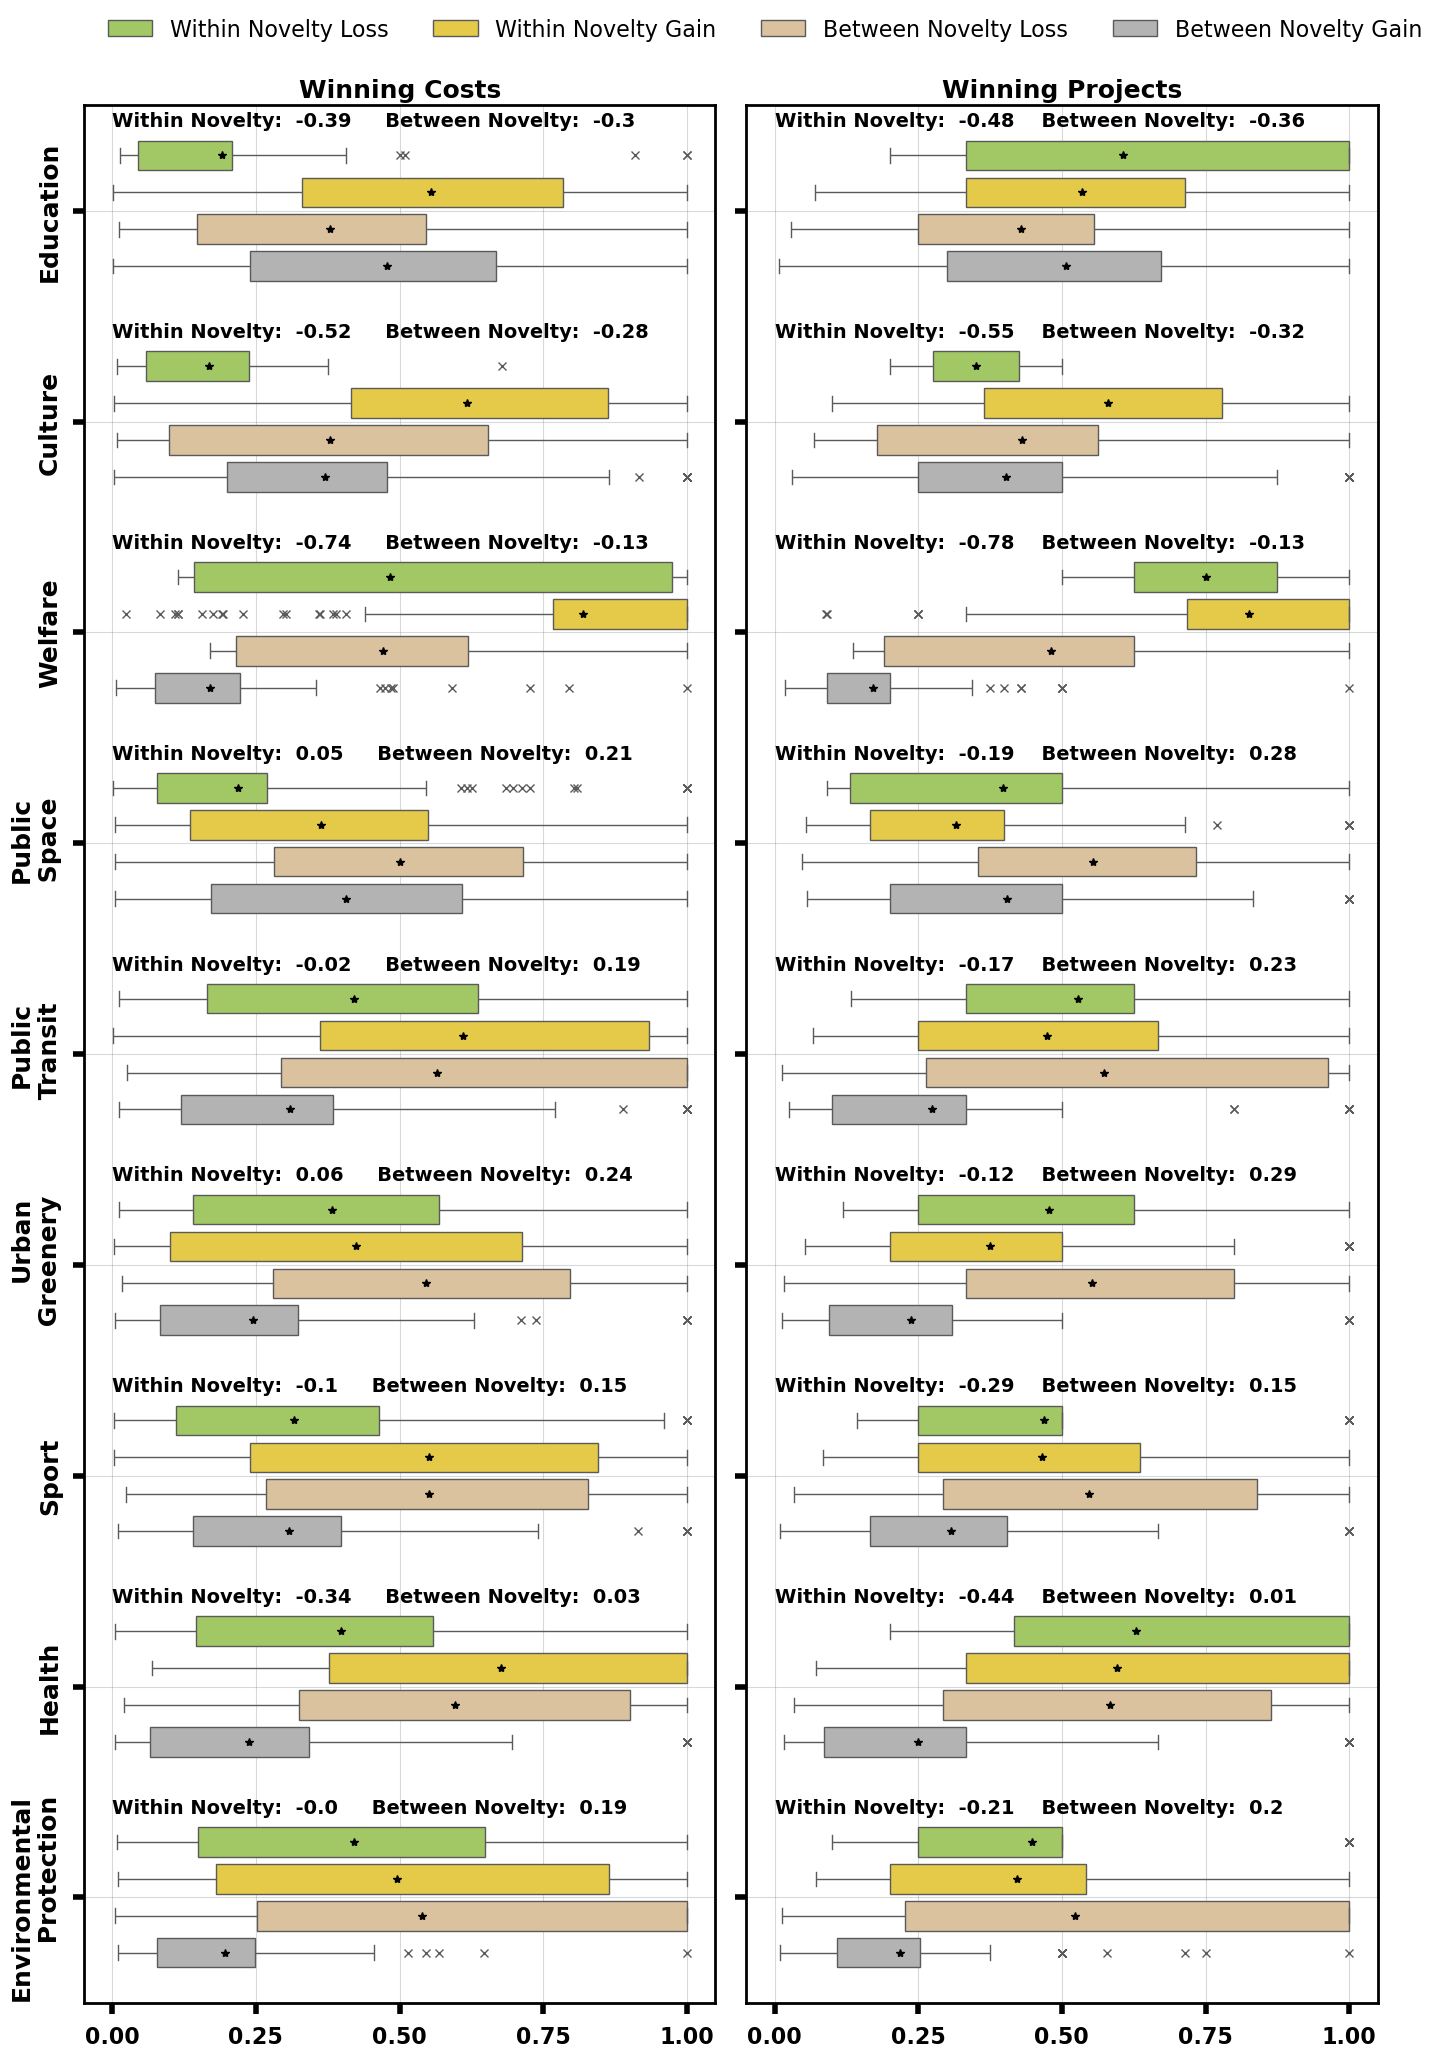

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 20), sharex=True, sharey=True)


novelty_color_palette = ['#a6d854','#ffd92f','#e5c494','#b3b3b3']

sns.boxplot(y='category', ax=axes[0], x='Winning Costs', hue='Winning Type', data=melted_cost_novelty_data, showmeans=True, medianprops={'visible': False}, flierprops={"marker": "x"}, width=0.7, meanprops={"marker":"*", "markerfacecolor":"black", "markeredgecolor":"black"}, palette=novelty_color_palette, dodge=True, gap=0.2)
sns.boxplot(y='category', ax=axes[1], x='Winning Projects', hue='Winning Type', data=melted_count_novelty_data, showmeans=True, medianprops={'visible': False}, flierprops={"marker": "x"}, width=0.7, meanprops={"marker":"*", "markerfacecolor":"black", "markeredgecolor":"black"}, palette=novelty_color_palette, dodge=True, gap=0.2)

# Customize legend
handles, labels = axes[0].get_legend_handles_labels()

# Create legend outside of the main plot
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.55, 1.001), ncols=4, frameon=False, fontsize=16)
fig.subplots_adjust(right=1)  # Adjust right side to fit legend

# Text overlay for overall novelty average of in between and within novelties
for idx, ((within_cost_key, within_cost_value), (between_cost_key, between_cost_value)) in enumerate(zip(within_novelty_cost_avg_map.items(), between_novelty_cost_avg_map.items())):
    if(within_cost_key == between_cost_key):
        axes[0].text(0, idx - 0.4, f'Within Novelty:  {within_cost_value}     Between Novelty:  {between_cost_value}', fontdict={'size':14, 'fontweight': 'bold'})

for idx, ((within_count_key, within_count_value), (between_count_key, between_count_value)) in enumerate(zip(within_novelty_count_avg_map.items(), between_novelty_count_avg_map.items())):
    if(within_count_key == between_count_key):
        axes[1].text(0, idx - 0.4, f'Within Novelty:  {within_count_value}    Between Novelty:  {between_count_value}', fontdict={'size':14, 'fontweight': 'bold'})

axes[0].legend().set_visible(False)
axes[1].legend().set_visible(False)

plt.xticks(np.arange(0, 1.1, 0.25), fontsize=12)

axes[0].set_ylabel('')
axes[1].set_ylabel('')

axes[0].set_xlabel('')
axes[1].set_xlabel('')

axes[0].set_title('Winning Costs', fontsize=18, fontdict={'fontweight': 'bold'})
axes[1].set_title('Winning Projects', fontsize=18, fontdict={'fontweight': 'bold'})

axes[0].tick_params(axis='both', labelsize=16, width=4, length=8, pad=8)
axes[1].tick_params(axis='both', labelsize=16, width=4, length=8, pad=8)

axes[0].set_xticklabels(axes[0].get_xticklabels(), fontweight='bold') 
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontweight='bold') 

axes[0].grid(axis='both', which='major', color='gray', alpha=0.3)
axes[1].grid(axis='both', which='major', color='gray', alpha=0.3)

# # Get the y-labels
labels = axes[0].get_yticklabels()


# Set bold font for y-labels
for label in labels:
    label.set_fontweight('bold')
    label.set_fontsize(18)
    label.set_rotation(90)
    label.set_verticalalignment('center') 

# Adjust the border thickness of subplots
for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Set border thickness to 2 points

plt.tight_layout()
plt.show()

### Adding a third column for Winning Votes; Novelty Based on Popularity

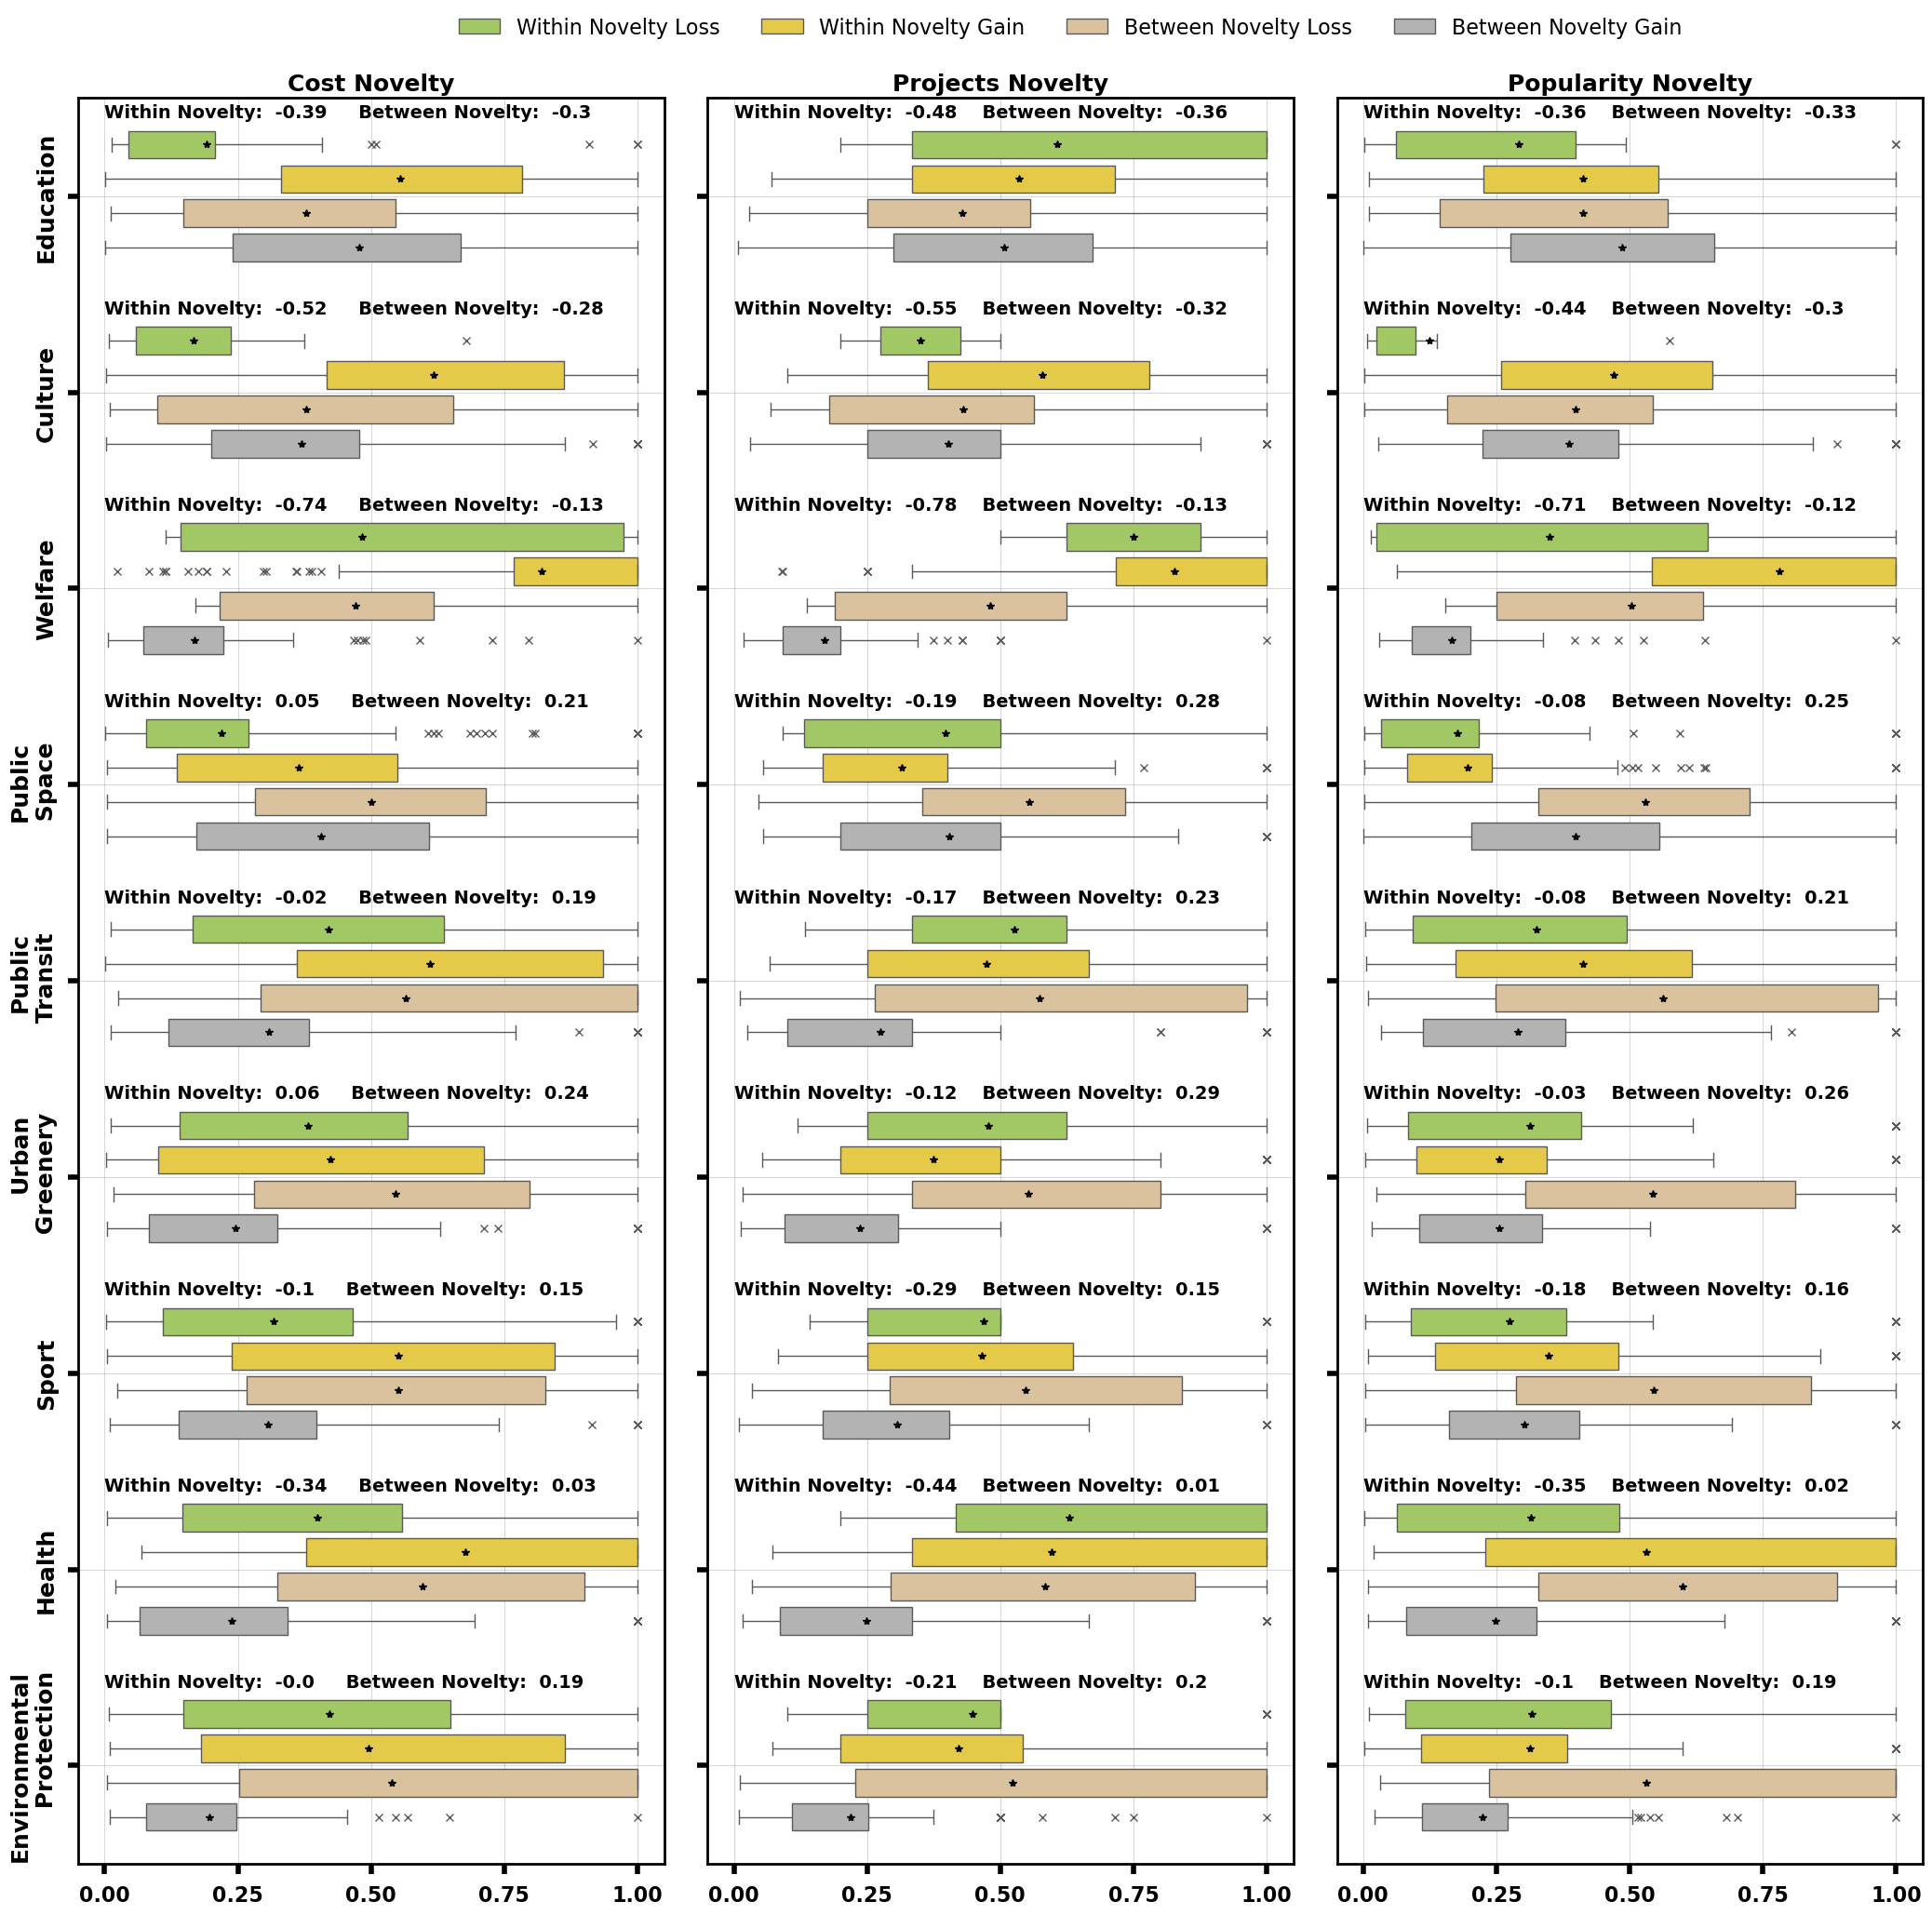

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(21, 20), sharex=True, sharey=True)


novelty_color_palette = ['#a6d854','#ffd92f','#e5c494','#b3b3b3']

sns.boxplot(y='category', ax=axes[0], x='Winning Costs', hue='Winning Type', data=melted_cost_novelty_data, showmeans=True, medianprops={'visible': False}, flierprops={"marker": "x"}, width=0.7, meanprops={"marker":"*", "markerfacecolor":"black", "markeredgecolor":"black"}, palette=novelty_color_palette, dodge=True, gap=0.2)
sns.boxplot(y='category', ax=axes[1], x='Winning Projects', hue='Winning Type', data=melted_count_novelty_data, showmeans=True, medianprops={'visible': False}, flierprops={"marker": "x"}, width=0.7, meanprops={"marker":"*", "markerfacecolor":"black", "markeredgecolor":"black"}, palette=novelty_color_palette, dodge=True, gap=0.2)
sns.boxplot(y='category', ax=axes[2], x='Winning Votes', hue='Winning Type', data=melted_popularity_novelty_data, showmeans=True, medianprops={'visible': False}, flierprops={"marker": "x"}, width=0.7, meanprops={"marker":"*", "markerfacecolor":"black", "markeredgecolor":"black"}, palette=novelty_color_palette, dodge=True, gap=0.2)

# Customize legend
handles, labels = axes[0].get_legend_handles_labels()

# Create legend outside of the main plot
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.55, 1.001), ncols=4, frameon=False, fontsize=16)
fig.subplots_adjust(right=1)  # Adjust right side to fit legend

# Text overlay for overall novelty average of in between and within novelties
for idx, ((within_cost_key, within_cost_value), (between_cost_key, between_cost_value)) in enumerate(zip(within_novelty_cost_avg_map.items(), between_novelty_cost_avg_map.items())):
    if(within_cost_key == between_cost_key):
        axes[0].text(0, idx - 0.4, f'Within Novelty:  {within_cost_value}     Between Novelty:  {between_cost_value}', fontdict={'size':14, 'fontweight': 'bold'})

for idx, ((within_count_key, within_count_value), (between_count_key, between_count_value)) in enumerate(zip(within_novelty_count_avg_map.items(), between_novelty_count_avg_map.items())):
    if(within_count_key == between_count_key):
        axes[1].text(0, idx - 0.4, f'Within Novelty:  {within_count_value}    Between Novelty:  {between_count_value}', fontdict={'size':14, 'fontweight': 'bold'})

for idx, ((within_count_key, within_count_value), (between_count_key, between_count_value)) in enumerate(zip(within_novelty_popularity_avg_map.items(), between_novelty_popularity_avg_map.items())):
    if(within_count_key == between_count_key):
        axes[2].text(0, idx - 0.4, f'Within Novelty:  {within_count_value}    Between Novelty:  {between_count_value}', fontdict={'size':14, 'fontweight': 'bold'})

axes[0].legend().set_visible(False)
axes[1].legend().set_visible(False)
axes[2].legend().set_visible(False)

plt.xticks(np.arange(0, 1.1, 0.25), fontsize=12)

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')

axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')

axes[0].set_title('Cost Novelty', fontsize=18, fontdict={'fontweight': 'bold'})
axes[1].set_title('Projects Novelty', fontsize=18, fontdict={'fontweight': 'bold'})
axes[2].set_title('Popularity Novelty', fontsize=18, fontdict={'fontweight': 'bold'})

axes[0].tick_params(axis='both', labelsize=16, width=4, length=8, pad=8)
axes[1].tick_params(axis='both', labelsize=16, width=4, length=8, pad=8)
axes[2].tick_params(axis='both', labelsize=16, width=4, length=8, pad=8)

axes[0].set_xticklabels(axes[0].get_xticklabels(), fontweight='bold') 
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontweight='bold') 
axes[2].set_xticklabels(axes[2].get_xticklabels(), fontweight='bold') 

axes[0].grid(axis='both', which='major', color='gray', alpha=0.3)
axes[1].grid(axis='both', which='major', color='gray', alpha=0.3)
axes[2].grid(axis='both', which='major', color='gray', alpha=0.3)

# # Get the y-labels
labels = axes[0].get_yticklabels()


# Set bold font for y-labels
for label in labels:
    label.set_fontweight('bold')
    label.set_fontsize(18)
    label.set_rotation(90)
    label.set_verticalalignment('center') 

# Adjust the border thickness of subplots
for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Set border thickness to 2 points

plt.tight_layout()
plt.show()

### Additional codeblocks for t-test on novelty metrics

In [43]:
# setting up the metrics for novelty
for category in categories_set:
    # 4 within novelty metrics
    categorization_df[f'ug_within_novelty_cost_{category}'] = categorization_df[f'{category}_excl_ug_total_cost'] / categorization_df[f'{category}_ug_total_cost']
    categorization_df[f'es_within_novelty_cost_{category}'] = categorization_df[f'{category}_excl_es_total_cost'] / categorization_df[f'{category}_es_total_cost']
    categorization_df[f'ug_within_novelty_count_{category}'] = categorization_df[f'{category}_excl_ug_total_projects'] / categorization_df[f'{category}_ug_total_projects']
    categorization_df[f'es_within_novelty_count_{category}'] = categorization_df[f'{category}_excl_es_total_projects'] / categorization_df[f'{category}_es_total_projects']
    categorization_df[f'ug_within_novelty_popularity_{category}'] = categorization_df[f'{category}_excl_ug_total_popularity'] / categorization_df[f'{category}_ug_total_popularity']
    categorization_df[f'es_within_novelty_popularity_{category}'] = categorization_df[f'{category}_excl_es_total_popularity'] / categorization_df[f'{category}_es_total_popularity']

    # 4 between novelty metrics
    categorization_df[f'ug_between_novelty_cost_{category}'] = categorization_df[f'{category}_excl_ug_total_cost'] / categorization_df['excl_ug_total_cost']
    categorization_df[f'es_between_novelty_cost_{category}'] = categorization_df[f'{category}_excl_es_total_cost'] / categorization_df[f'excl_es_total_cost']
    categorization_df[f'ug_between_novelty_count_{category}'] = categorization_df[f'{category}_excl_ug_total_projects'] / categorization_df['excl_ug_total_projects']
    categorization_df[f'es_between_novelty_count_{category}'] = categorization_df[f'{category}_excl_es_total_projects'] / categorization_df['excl_es_total_projects']
    categorization_df[f'ug_between_novelty_popularity_{category}'] = categorization_df[f'{category}_excl_ug_total_popularity'] / categorization_df['excl_ug_total_popularity']
    categorization_df[f'es_between_novelty_popularity_{category}'] = categorization_df[f'{category}_excl_es_total_popularity'] / categorization_df['excl_es_total_popularity']

C:\Users\scsmah\AppData\Local\Temp\ipykernel_26824\706377393.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'ug_within_novelty_cost_{category}'] = categorization_df[f'{category}_excl_ug_total_cost'] / categorization_df[f'{category}_ug_total_cost']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_26824\706377393.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'es_within_novelty_cost_{category}'] = categorization_df[f'{category}_excl_es_total_cost'] / categorization_df[f'{category}_es_tot

In [44]:
# cols to select
cols_to_select = ['election_id']
for category in categories_set:
    cols_to_select.append(f'ug_within_novelty_cost_{category}')
    cols_to_select.append(f'es_within_novelty_cost_{category}')
    cols_to_select.append(f'ug_within_novelty_count_{category}')
    cols_to_select.append(f'es_within_novelty_count_{category}')
    cols_to_select.append(f'ug_within_novelty_popularity_{category}')
    cols_to_select.append(f'es_within_novelty_popularity_{category}')

    cols_to_select.append(f'ug_between_novelty_cost_{category}')
    cols_to_select.append(f'es_between_novelty_cost_{category}')
    cols_to_select.append(f'ug_between_novelty_count_{category}')
    cols_to_select.append(f'es_between_novelty_count_{category}')
    cols_to_select.append(f'ug_between_novelty_popularity_{category}')
    cols_to_select.append(f'es_between_novelty_popularity_{category}')

per_election_novelty_metrics = categorization_df[cols_to_select]
per_election_novelty_metrics.drop_duplicates(inplace=True)
print(per_election_novelty_metrics.shape)

(346, 109)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_26824\2550547820.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_election_novelty_metrics.drop_duplicates(inplace=True)


In [45]:
# paired t-tests
ttest_stats = pd.DataFrame(columns=['metric', 'category', 't-statistic', 'p-value'])

from scipy.stats import ttest_rel

# for budget share across each category
print("\n---------------------- Paired T-tests on Within Novelty Winning Cost ----------------------")
for category in categories_set:
    temp_df = per_election_novelty_metrics[[f'ug_within_novelty_cost_{category}', f'es_within_novelty_cost_{category}']]
    temp_df_cleaned = temp_df.dropna()
    tstats, pvalue = ttest_rel(temp_df_cleaned[f'ug_within_novelty_cost_{category}'], temp_df_cleaned[f'es_within_novelty_cost_{category}'])
    ttest_stats.loc[len(ttest_stats)] = {'metric': 'Within-Novelty Cost', 'category': category, 't-statistic': tstats, 'p-value': pvalue }

print("\n---------------------- Paired T-tests on Within Novelty Winning Count ----------------------")
for category in categories_set:
    temp_df = per_election_novelty_metrics[[f'ug_within_novelty_count_{category}', f'es_within_novelty_count_{category}']]
    temp_df_cleaned = temp_df.dropna()
    tstats, pvalue = ttest_rel(temp_df_cleaned[f'ug_within_novelty_count_{category}'], temp_df_cleaned[f'es_within_novelty_count_{category}'])
    ttest_stats.loc[len(ttest_stats)] = {'metric': 'Within-Novelty Count', 'category': category, 't-statistic': tstats, 'p-value': pvalue }

print("\n---------------------- Paired T-tests on Within Novelty Popularity ----------------------")
for category in categories_set:
    temp_df = per_election_novelty_metrics[[f'ug_within_novelty_popularity_{category}', f'es_within_novelty_popularity_{category}']]
    temp_df_cleaned = temp_df.dropna()
    tstats, pvalue = ttest_rel(temp_df_cleaned[f'ug_within_novelty_popularity_{category}'], temp_df_cleaned[f'es_within_novelty_popularity_{category}'])
    ttest_stats.loc[len(ttest_stats)] = {'metric': 'Within-Novelty Popularity', 'category': category, 't-statistic': tstats, 'p-value': pvalue }

print("\n---------------------- Paired T-tests on Between-Novelty Cost ----------------------")
for category in categories_set:
    temp_df = per_election_novelty_metrics[[f'ug_between_novelty_cost_{category}', f'es_between_novelty_cost_{category}']]
    temp_df_cleaned = temp_df.dropna()
    tstats, pvalue = ttest_rel(temp_df_cleaned[f'ug_between_novelty_cost_{category}'], temp_df_cleaned[f'es_between_novelty_cost_{category}'])
    ttest_stats.loc[len(ttest_stats)] = {'metric': 'Between-Novelty Cost', 'category': category, 't-statistic': tstats, 'p-value': pvalue }

print("\n---------------------- Paired T-tests on Between-Novelty Count ----------------------")
for category in categories_set:
    temp_df = per_election_novelty_metrics[[f'ug_between_novelty_count_{category}', f'es_between_novelty_count_{category}']]
    temp_df_cleaned = temp_df.dropna()
    tstats, pvalue = ttest_rel(temp_df_cleaned[f'ug_between_novelty_count_{category}'], temp_df_cleaned[f'es_between_novelty_count_{category}'])
    ttest_stats.loc[len(ttest_stats)] = {'metric': 'Between-Novelty Count', 'category': category, 't-statistic': tstats, 'p-value': pvalue }

print("\n---------------------- Paired T-tests on Between-Novelty Popularity ----------------------")
for category in categories_set:
    temp_df = per_election_novelty_metrics[[f'ug_between_novelty_popularity_{category}', f'es_between_novelty_popularity_{category}']]
    temp_df_cleaned = temp_df.dropna()
    tstats, pvalue = ttest_rel(temp_df_cleaned[f'ug_between_novelty_popularity_{category}'], temp_df_cleaned[f'es_between_novelty_popularity_{category}'])
    ttest_stats.loc[len(ttest_stats)] = {'metric': 'Between-Novelty Popularity', 'category': category, 't-statistic': tstats, 'p-value': pvalue }

ttest_stats.to_csv('./paired_t_test_novelty_metrics.csv', index=False)


---------------------- Paired T-tests on Within Novelty Winning Cost ----------------------

---------------------- Paired T-tests on Within Novelty Winning Count ----------------------

---------------------- Paired T-tests on Within Novelty Popularity ----------------------

---------------------- Paired T-tests on Between-Novelty Cost ----------------------

---------------------- Paired T-tests on Between-Novelty Count ----------------------

---------------------- Paired T-tests on Between-Novelty Popularity ----------------------


In [46]:
ttest_stats

,metric,category,t-statistic,p-value
0,Within-Novelty Cost,education,-13.4261,0.0000
1,Within-Novelty Cost,public_transit_and_roads,0.4005,0.6891
2,Within-Novelty Cost,health,-4.3531,0.0000
3,Within-Novelty Cost,welfare,-6.5998,0.0000
4,Within-Novelty Cost,public_space,2.5088,0.0126
...,...,...,...,...
49,Between-Novelty Popularity,public_space,8.0770,0.0000
50,Between-Novelty Popularity,urban_greenery,7.4245,0.0000
51,Between-Novelty Popularity,culture,-12.9300,0.0000
52,Between-Novelty Popularity,sport,4.6445,0.0000
